# Degerby Proxy

Time series of daily Baltic Sea volume, reconstructed
from  observations  of  sea  surface  elevation  at  tide
gauge Degerby, are available for 9 yr, i.e. 1980 to 1988
(Launiainen & Vihma 1990b). It is well known that sea
level  change  in  the  centre  of  the  Baltic  Sea  (e.g.
Degerby  or  Landsort)  is  representative  of  volume
change,  i.e.  the  mean  sea  level  change  of  the  whole
Baltic Sea (e.g. Jacobsen 1980).

# About GESLA3

We converted height units to metres, the time zone of each record was adjusted to Coordinated Universal Time (UTC).

We did not adjust the frequency of the station records, which in all cases was at least hourly, although several sources have data at higher-frequency (15, 10 or 6 minutes)

We use total water levels from the GESLA-2 
dataset (Tiggeloven 2021)

# Main

- Think about scaling predictors if they are combined!

In [1]:
def predictor_maps(model, X_test, y_test, X_test_unscaled, ndim, n_pfs, is_pf_combined, lons, lats, pred_units, pred_names, station_positions, station_names, is_station_name, is_overlay_importance, run_id, model_run, percentile, markersize, alpha, color, colorbar_range, nlevels=10):
    """
    Description:
        Plots values of all predictors used for model training. Selects timepoints where Storm Surges were in original data and indicates whether 
        the prediction was true or not in the filename ("isfalse", "istrue"). The file naming "predss" is for situations, where a storm surge was predicted
        but the original data has no storm surge.
    Parameters:
        model (clf): Model that was fitted to X_test, y_test.
        X_test (): Test set of predictor data used for model fit
        y_test (): Test set of predictand data used for model fit
        lons (): Values of longitudes of predictors
        lats (): Values of latitudes of predictors
        pred_units (list): Units of all predictors used, e.g. ms**-1
        pred_names (list): Names of all predictors used, e.g. sp_tlag0
        station_positions (dict,): Dicitionary with station name (key) and a list of [lon, lat] (values)
        station_name (str): Name of the station given in GESLA dataset.
        is_station_name (bool): Whether to indicate station name in plot or not (Defaults: False)
        is_overlay_importance (bool): Overlay values of importance of that predictor or not
        run_id (int): Number of the model run
        model_run (str): Name of the current model run
        percentile (float): Percentile (0-100) for selecting position of overlayed importance
        markersize (int): Size of square-marked positions of importance
        alpha (float): Transparency of square-markers for importance
        color (str): Color of square-marker for importance
        colorbar_range (dict): Keys are predictors (e.g. "sp"), values are list of [vmin, vmax] values for colorbar
        nlevels (int): Number of levels in contour plot (e.g. sections of the colorbar) (Defaults: 10)

    Returns:
        None
    """
    #---
    # Make a prediction
    #---
    nlat = lats.size
    nlon = lons.size
    y_test_pred = model.predict(X_test) # Predicted data
    importance = model.feature_importances_
    n_pred_features = nlon * nlat # Features per predictor (lon/lat Input-Field). Needed for importance separation

    # Get importance per predictor of model
    #---
    if is_pf_combined:
        importance = importance[:-n_pfs] # Select only values that contain era5 as predictor
        X_test = X_test[:, :-n_pfs]
        X_test_unscaled = X_test_unscaled[:, :-n_pfs]

    predictor_importances = evaluation.separate_predictor_importance(importance, n_pred_features) #

    #---
    # Select data for plotting original storm surge events
    #---
    ss_idx = np.where(y_test == 1) # Timepoints of storm surges in original data

    y_test_ss = y_test[ss_idx] # Original data storm surges only
    y_pred_ss = y_test_pred[ss_idx] # Predictions at timepoints of SS in original data

    ntime = X_test.shape[0]
    X_pred = X_test_unscaled.reshape(ntime, -1, nlat, nlon) # Reshape to fit format for plotting predictor values on a map TODO: Needs to be adjusted to unscaled values?

    X_pred_plot = X_pred[ss_idx] # Select only predictor values at timepoints of storm surges

    #---
    # Plot & Save predictor map at original storm surge events
    #---
    n_time = X_pred_plot.shape[0]
    n_pred = X_pred_plot.shape[1]

    time_idx = 0
    for time in range(n_time):

        is_correct_prediction = (y_test_ss[time] == y_pred_ss[time])

        for pred_idx in range(n_pred):
            pred_flag = pred_names[pred_idx].split("_")[0] # Split because string is "tp_tlag0" etc.
            # Convert unit of colorbar
            #---
            unit = pred_units[pred_idx]
            if (unit == "m s**-1"): 
                unit = "m/s"

            # Create Figure
            #---
            data = X_pred_plot[time, pred_idx, :, :].flatten() # Predictor data

            if is_correct_prediction:
                tflag = f"{pred_names[pred_idx]}, y_orig = 1, y_pred = 1"
                fname = f"{pred_names[pred_idx]}_{time_idx}_istrue_{run_id}"
            else:
                tflag = f"{pred_names[pred_idx]}, y_orig = 1, y_pred = 0" 
                fname = f"{pred_names[pred_idx]}_{time_idx}_isfalse_{run_id}"
            
            # Get colorbar vmin vmax
            #---
            vmin = colorbar_range[pred_flag][0] 
            vmax = colorbar_range[pred_flag][1]

            # Choose colormap
            #---
            if pred_flag == "sp":
                cmap = "coolwarm"
            elif pred_flag == "tp":
                cmap = "Blues"
            elif (pred_flag == "u10" or pred_flag == "v10"):
                cmap= "seismic"

            # Plot figure
            #---
            fig, ax = visualisation.map(data, lons, lats, tflag=tflag, unit=unit, vmin=vmin, vmax=vmax, nlevels=nlevels, cmap=cmap)
            
            # Add position of station to map
            #---
            for station_name in station_names:
                visualisation.plot_station(ax, station_positions, station_name, is_station_name)

            # Add importance to map
            #---
            if is_overlay_importance:
                pred_importance = predictor_importances[pred_idx]
                evaluation.overlay_importance(ax, pred_importance, lats, lons, percentile=percentile, alpha=alpha, markersize=markersize, color=color)

            # Save plot
            #---
            folder1 = f"results/random_forest/{model_run}/predictor_maps/"
            saver.directory_existance(folder1)

            fig.savefig(f"{folder1}{fname}.pdf")

        time_idx = time_idx + 1

    #---
    # Plot & Save predictor map of predicted storm surge events where original data has no storm surge 
    #---
    idx2 = np.where(y_test_pred == 1) # Select all occurences where prediction has SS
    y_test_idx2 = y_test[idx2]
    X_pred_plot = X_pred[idx2]
    idx3 = np.where(y_test_idx2 == 0) # Subselect all occurences where prediction has SS and original data has no SS
    X_pred_plot = X_pred_plot[idx3] # Choose this selection as a plot
    n_time = X_pred_plot.shape[0]
    n_pred = X_pred_plot.shape[1]

    for time in range(n_time):
        for pred_idx in range(n_pred):
            pred_flag = pred_names[pred_idx].split("_")[0] # Split because string is "tp_tlag0" etc.
            # Convert unit of colorbar
            #---
            unit = pred_units[pred_idx]
            if (unit == "m s**-1"): 
                unit = "m/s"

            # Create Figure
            #---
            data = X_pred_plot[time, pred_idx, :, :].flatten() # Predictor data

            tflag = f"{pred_names[pred_idx]},  y_orig = 0, y_pred = 1"
            
            # Get colorbar vmin vmax
            #---
            vmin = colorbar_range[pred_flag][0] # Split because string is "tp_tlag0" etc.
            vmax = colorbar_range[pred_flag][1]

            # Choose colormap
            #---
            if pred_flag == "sp":
                cmap = "coolwarm"
            elif pred_flag == "tp":
                cmap = "Blues"
            elif (pred_flag == "u10" or pred_flag == "v10"):
                cmap= "seismic"
                
            # Plot figure
            #---
            fig, ax = visualisation.map(data, lons, lats, tflag=tflag, unit=unit, vmin=vmin, vmax=vmax, nlevels=nlevels, cmap=cmap)

            # Add position of station to plot
            #---
            for station_name in station_names:
                visualisation.plot_station(ax, station_positions, station_name, is_station_name)

            # Add importance to map
            if is_overlay_importance:
                pred_importance = predictor_importances[pred_idx]
                evaluation.overlay_importance(ax, pred_importance, lats, lons, percentile=percentile, alpha=alpha, markersize=markersize, color=color)
            
            # Save figure
            #---
            folder1 = f"results/random_forest/{model_run}/predictor_maps/"
            saver.directory_existance(folder1)

            fname = f"{pred_names[pred_idx]}_{time_idx}_predss_{run_id}"

            fig.savefig(f"{folder1}{fname}.pdf")

        time_idx = time_idx + 1

In [3]:
#---
# Modules
#---
import numpy as np
import xarray as xr
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


from data import data_loader
from data import gesla_preprocessing
from data import era5_preprocessing
from data import preprocessing
from data import saver
from data import visualisation

from models import modelfit
from models import evaluation
from models import loader

In [4]:
#---
# Modules
#---
import numpy as np
import xarray as xr
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


from data import data_loader
from data import gesla_preprocessing
from data import era5_preprocessing
from data import preprocessing
from data import saver
from data import visualisation

from models import modelfit
from models import evaluation
from models import loader


def run(
model_run, 
run_id, 
season,
station_names,
detrend_type, 
predictors_of_model, 
timelags_of_model, 
models_path, 
percentile, 
clf, 
hparam_grid, 
optimizer, 
k, 
n_iter, 
random_state,
test_size,
is_optimized, 
is_scaled,
is_overlay_importance,
is_station_name,
):
    """
    Description:
        Builds a model to predict (percentile) extreme storm surges at station_names using predictors for a specified season by using
        a classifier.
    Parameters:
        season (str): Either winter or autumn
        predictors (list): List of predictors (X) used to predict Storm Surge (y)
        percentile (float): Percentile of Extreme Storm Surges
        station_names (list): List of stations used from GESLA data-set
        detrend_type (str): "constant" or "linear" for detrending GESLA Dataset with mean or linear-trend, respectively.
        clf (sklearn.modeltype): Used model to do prediction, e.g. RandomForestClassifier, LogisticRegression,...
        hparam_grid (dict): Selection of multiple Hyperparameters either used for building the model or fitted 
                            to clf via the optimizer depending on is_optimized.
                            If hparam_grid is used for optimization, values of dictionary need to be lists.
        optimizer (str): Optimizer for automatic search of hyperparameters, either GridSearchCV or RandomSearchCV
        run_id (int): Number of the run (used for saving output)
        model_run (str): Naming of the model run (used for saving output)
        k (int): Number of k-fold crossvalidations in model fit (Defaults: 3)
        n_iter (int): Number of combinations used for RandomizedSearchCV (Defaults: None)
        is_optimized (bool): Whether or not to search best combination of hparams within hparam_grid with 
                             the optimizer (Defaults: True)
                             If is_optiomized == False, hyperparameters are loaded from a model given in models_path
        is_scaled (bool): Use StandardScaler to scale data if it is on different scales (Defaults: False)
        is_overlay_importance (bool): Whether to plot predictor maps with overlayed importance positions
        is_station_name (bool): Whether to plot station name over station itself.
    Returns:
        None. Saves Output in results>random_forest>model_run folder. Saves model in models>random_forest>model_run
    """
    import sys
    #--- 
    # Initialize
    #---
    preprocess = "preprocess1" # ["preprocess1"]
    range_of_years = "1999-2008" # ["1999-2008", "2009-2018", "2019-2022",] 
    unknown_range_of_years = "2009-2018"
    subregion = "lon-0530_lat7040" # ["lon-0530_lat7040"]
    lats, lons = preprocessing.get_lonlats(
        range_of_years,
        subregion,
        season,
        predictor="sp", # Does not matter which predictor. All predictors are sampled on same lon-lat field.
        era5_import=preprocess,
        )
    colorbar_range = { # vmin vmax values for colorbar of predictor maps
        'sp': np.array([ 980., 1020.,]),  # Low pressure systems <980hPa (see Theory Part)
        'tp': np.array([0.    , 0.0018]),
        'u10': np.array([-17.2,  17.2]), # Storm is defined by wind stronger than 17.2m/s
        'v10': np.array([-17.2,  17.2]),
        }
    nlevels = 10 # For contourplot of predictor maps
    orig_stdout = sys.stdout # Original Output for print etc.
    
    #---
    # Preprocess GESLA Data
    #---

    # Load Predictand
    #---
    gesla_predictand = data_loader.load_gesla(station_names)

    # Get lon/lat positions of stations
    #---
    station_positions = gesla_preprocessing.station_position(gesla_predictand, station_names)

    # Select a season
    #---
    gesla_predictand = gesla_preprocessing.select_season(gesla_predictand, season)

    # Select only sea_level analysis data
    #---
    gesla_predictand = gesla_preprocessing.get_analysis(gesla_predictand)
    gesla_predictand = gesla_predictand["sea_level"] # Select values

    # Detrend 
    #---
    gesla_predictand = gesla_preprocessing.detrend_signal(gesla_predictand, type_=detrend_type) 

    # Apply one hot encoding
    #---
    gesla_predictand = gesla_preprocessing.apply_dummies(gesla_predictand, percentile=percentile, level="station")
    print(f"Applied one-hot-encoding with Percentile: {percentile}")

    # Convert to DataArray
    # nan values: no measurement at that timestamp for specific station
    #---
    gesla_predictand = gesla_predictand.to_xarray()

    #---
    # Loop over all run_ids of a model_run / predictors
    #---
    for idx, predictors in enumerate(predictors_of_model): # Loops over separate modelruns 
        
        #---
        # Save printed output to file
        #---
        folder = f"results/random_forest/{model_run}/"
        saver.directory_existance(folder)
        file_path = f'{folder}output_runid{run_id}.txt'
        sys.stdout = open(file_path, "w") 

        #---
        # Load ERA5- Predictor
        #---
        
        # Initialize
        #---
        timelags = timelags_of_model[idx]

        if ("pf" in predictors) and (("sp" or "tp" or "u10" or "v10") in predictors):
            is_pf_combined = True
            print("Prefilling is combined with ERA5 Predictors")
        else:
            is_pf_combined = False
            print("Prefilling is either not used or used alone as a predictor.")
        X = []
        Y = []
        t = []
        pred_units = []
        pred_names = []
        tic_main = time.perf_counter()

        if is_pf_combined==True:
            ts = preprocessing.intersect_all_times(predictors, gesla_predictand, range_of_years, subregion, season, preprocess)

        # Main
        #---
        era5_counter = 0
        for pred_idx, predictor in enumerate(predictors):
            print(f"Add predictor {predictor} to model input features")

            # Load data of predictor
            #---
            import xarray as xr
            if predictor == "pf":
                is_prefilled = True

                era5_predictor = data_loader.load_pf(season)

                if is_pf_combined:
                    X_ = preprocessing.get_timeseries(era5_predictor, ts, is_prefilling=True)
                    Y_ = preprocessing.get_timeseries(gesla_predictand, ts, is_prefilling=True)
                else:
                    # If pf is used without any ERA5 data, use hourly data of Degerby.
                    X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand, is_prefilled) 

            else:
                is_prefilled = False
                era5_counter = era5_counter + 1
                era5_predictor = data_loader.load_daymean_era5(range_of_years, subregion, season, predictor, preprocess) # TODO: Change back to range_of_years
                era5_predictor = preprocessing.convert_timestamp(era5_predictor, dim="time")

                # Convert predictor sp.unit from Pa to hPA
                #---
                if predictor == "sp":
                    with xr.set_options(keep_attrs=True):
                        old_unit = era5_predictor.attrs["units"]
                        era5_predictor = era5_predictor / 100
                        era5_predictor.attrs["units"] = "hPa"
                        new_unit = era5_predictor.attrs["units"]
                        print(f"Converted units of {predictor} from {old_unit} to {new_unit}")

                if is_pf_combined:
                    X_ = preprocessing.get_timeseries(era5_predictor, ts, is_prefilling=False)
                    Y_ = preprocessing.get_timeseries(gesla_predictand, ts, is_prefilling=True)
                else:
                    X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand, is_prefilled)

            
            #---
            # Get timelags
            #---
            print(f"Introduce timelag: {timelags[pred_idx]} for {predictor}")
            print(f"Shapes X_: {X_.shape}, Y_: {Y_.shape}")

            X_timelag, Y_timelag = preprocessing.add_timelag(X_, Y_, timelags, pred_idx) 

            X.append(X_timelag)
            Y.append(Y_timelag)
            # t.append(t_)

            # # Save unit and name of predictor
            # #---
            if predictor == "pf":
                pred_units.append("m")
                if is_pf_combined:
                    pred_names.append(f"{predictor}_tlag{timelags[pred_idx]}") # Daily values of timelags if is_pf_combined
                else:
                    pred_names.append(f"{predictor}_tlag{timelags[pred_idx] // 24}") # Hourly values converted back to daily values for interpretation
            else:
                pred_units.append(era5_predictor.units)
                pred_names.append(f"{era5_predictor.name}_tlag{timelags[pred_idx]}")
        
        #--- 
        # Convert to format needed for model fit
        #---
        if is_pf_combined:
            Y = np.array(Y) 
            Y = Y[0, :] # Assume all timeseries are the same for the predictors.
            ndim = Y.shape[0]
            max_length = len(X)
            n_pfs = max_length - era5_counter # Number of prefilling predictors

            print(era5_counter, max_length, n_pfs, ndim)

            era5_x = np.array(X[:era5_counter])
            era5_x = era5_x.swapaxes(0, 1)
            era5_x = era5_x.reshape(ndim, -1)

            print(f"ERA5 shape: {era5_x.shape}")

            #--- 
            # Insert prefilling data at the beginning
            #---
            XX = era5_x
            new_names = pred_names
            new_units = pred_units
            for i in range(era5_counter, max_length):
                print(f"Add Predictor {pred_names[i]} to end of X")
                XX = np.append(XX, X[i], axis=1)


            y = Y[:, 0] # Select one station

            #---
            # Handle NaN Values
            #---

            # Insert numerical value that is not in data.
            # ML will hopefully recognize it.
            XX[np.where(np.isnan(XX))] = -999

            X = XX
            
            del XX
            print("Data is prepared as follows")
            print(f"X.shape : {X.shape}")
            print(f"y.shape : {y.shape}")
            print(f"pred_names : {pred_names}")
            print(f"pred_units : {pred_units}")
        else:
            # Convert to format needed for model fit
            #--- 
            max_length = len(X)
            n_pfs = max_length - era5_counter # Number of prefilling predictors

            X = np.array(X)
            Y = np.array(Y) 
            Y = Y[0, :] # Assume all timeseries are the same for the predictors.
            t = np.array(t)

            # Reshape for model input
            #---
            print(f"Reshape for model input")

            ndim = Y.shape[0]

            X = X.swapaxes(0, 1) # Put time dimension to front

            print(X.shape) # (time, timelags, predictor_combination, lon?, lat?)

            X = X.reshape(ndim, -1) # Reshapes into (time, pred1_lonlats:pred2_lonlats:...:predn_lonlats)
            y = Y[:, 0] # Select one station

            #---
            # Handle NaN Values
            #---

            # Insert numerical value that is not in data.
            # ML will hopefully recognize it.
            X[np.where(np.isnan(X))] = -999

            print("Data is prepared as follows")
            print(f"X.shape : {X.shape}")
            print(f"y.shape : {y.shape}")
            print(f"pred_names : {pred_names}")
            print(f"pred_units : {pred_units}")
        
        #---
        # Apply Train-Test split 
        #---
        print("Apply train-test-split")
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=test_size)

        #---
        # Scale data if they are on different scales
        #---
        X_test_unscaled = X_test

        if is_scaled:
            print("Scale training data")
            s = StandardScaler()
            s.fit(X_train)
            X_train = s.transform(X_train)
            X_test = s.transform(X_test)

        #---
        #  Optimize Hyperparameters
        #---
        if is_optimized:
            print(f"Optimize Hyperparameters using {optimizer}")
            print(f"Tested Hyperparameters: {hparam_grid}")
            
            hparam_grid_opt = modelfit.optimize_hyperparameter(X_train, y_train, clf(), optimizer, hparam_grid, k, n_iter, n_jobs=-1)

        if not is_optimized:
            model_path = models_path[idx]
            print(f"Hyperparameters are loaded from model: {model_path}")
            with open(model_path, 'rb') as f:
                model = pickle.load(f)

            hparam_grid_opt = model.get_params()
            
        #---
        #  Save hyperparameters
        #---
        folder = f"models/random_forest/{model_run}/" 
        saver.directory_existance(folder)
        saver.save_hpdict(hparam_grid_opt, run_id, model_run, percentile, folder)

        print("Saved Hyperparameters")

        #---
        # Fit the model
        #---
        print(f"Fit model with hyperparameters {hparam_grid_opt}")

        model = clf(**hparam_grid_opt) # One can set parameters afterwards via model.set_params() 

        model.fit(X_train, y_train)

        #---
        # Saving the model
        #---
        print(f"Save model: {model}")
        filename = f'{model_run}_{optimizer}_{run_id}.sav'
        pickle.dump(model, open(f'{folder}{filename}', 'wb'))

        #---
        # Plot Predictor Maps
        #---
        tic_predmap = time.perf_counter()

        if era5_counter != 0: # Do not print predictor maps if only prefilling is used as predictor. Otherwise print predictor maps
                print(f"Plot predictor maps")
                visualisation.predictor_maps( # TODO: If only pf is used this should be skipped, e.g. no plotting of importance maps
                        model, X_test, y_test,
                        X_test_unscaled,
                        ndim, n_pfs, is_pf_combined, # Needed to separate ERA5 importance from Prefilling importance
                        lons, lats, pred_units, pred_names, 
                        station_positions, station_names, is_station_name, 
                        is_overlay_importance, 
                        run_id, model_run, 
                        percentile=99., markersize=5, alpha=0.08, color="k", colorbar_range=colorbar_range, nlevels=nlevels,
                        )
        toc_predmap = time.perf_counter()
        time_predmap = toc_predmap - tic_predmap # Save time of this separately as it is not necessary for model predictions

        #---
        # Evaluate model / Diagnostic
        #--- 
        print("Evaluate Model \n")

        # Score & Importance
        #---
        test_score = model.score(X_test, y_test)
        train_score = model.score(X_train, y_train)
        relative_score = evaluation.relative_scores(train_score, test_score)
        importance = model.feature_importances_

        # Save Scores & Importance
        #---
        folder = f"results/random_forest/{model_run}/"
        saver.directory_existance(folder)

        fname = f"importance_{str(percentile)[-2:]}_{run_id}"
        np.save(f"{folder}{fname}", importance)
        print(f"saved importance to : {folder}{fname}")

        fname = f"testscore_{str(percentile)[-2:]}_{run_id}"
        np.save(f"{folder}{fname}", test_score)
        print(f"saved testscore to : {folder}{fname}")

        fname = f"trainscore_{str(percentile)[-2:]}_{run_id}"
        np.save(f"{folder}{fname}", train_score)
        print(f"saved trainscore to : {folder}{fname}")

        fname = f"relativescore_{str(percentile)[-2:]}_{run_id}"
        np.save(f"{folder}{fname}", relative_score)
        print(f"saved relativescore to : {folder}{fname}")
        

        # Plot importance of each predictor from combination
        # Goal:
        # 1. Separate importance per predictor
        # 2. Plot importance of each predictor on lon lat map
        #---
        n_pred_features = len(lons) * len(lats) # Features per predictor (lon/lat Input-Field). Needed for importance separation

        if is_pf_combined:
            pf_importance = importance[-n_pfs:] 
            era5_importance = importance[:-n_pfs]
            predictor_importances = evaluation.separate_predictor_importance(era5_importance, n_pred_features) # Plot only importance map of era5 data
        else:
            if era5_counter != 0: # Only plot predictor importance if at least one predictor is ERA5
                predictor_importances = evaluation.separate_predictor_importance(importance, n_pred_features)
        
        if era5_counter !=0: # Only plot predictor importance if at least one predictor is ERA5
            for pred_idx, pred_importance in enumerate(predictor_importances): # TODO: If only pf is used this should be skipped, e.g. no plotting of importance maps
                # Plot importance map and save it
                predictor = pred_names[pred_idx] 
                tflag = f"{predictor}_{str(percentile)[-2:]}"
                
                if predictor == "pf": # Dont plot predictor importance if predictor is "pf"
                    pass
                else: # Only plot predictor importance on map if predictor is ERA5
                    fig, ax = evaluation.importance_map(pred_importance, lons, lats, tflag)

                    # Add position of station to map
                    #---
                    for station_name in station_names:
                        visualisation.plot_station(ax, station_positions, station_name, is_station_name)
                        
                    fname = f"importance_{predictor}_{str(percentile)[-2:]}_{run_id}"
                    fig.savefig(f"{folder}{fname}.pdf")

        #---
        # Confusion matrix
        #---
        # Format: 
        # Reality / Model: Negative, Positive
        # Negative    Right Negative, False Positive 
        # Positive    False Negative, Right Positive

        print("Show Confusion Matrix on testdata \n")
        cfm_fig1 = evaluation.plot_cf(model, X_test, y_test)
        cfm_fig1.show()

        print("Show Confusion Matrix on traindata \n")
        cfm_fig2 = evaluation.plot_cf(model, X_train, y_train)
        cfm_fig2.show()

        # Save CFM
        fname = f"{folder}testcf_matrix_{str(percentile)[-2:]}_{run_id}.pdf"
        cfm_fig1.savefig(fname)
        print(f"saved cf matrix to : {fname}")

        fname = f"{folder}traincf_matrix_{str(percentile)[-2:]}_{run_id}.pdf"
        cfm_fig2.savefig(fname)
        print(f"saved cf matrix to : {fname}")

        # Calculate CFM-Metrics
        print("Evaluate CFM Metrics of test data")
        metrics1 = evaluation.cfm_metrics(model, X_test, y_test)
        
        print("Evaluate CFM Metrics of train data")
        metrics2 = evaluation.cfm_metrics(model, X_train, y_train)

        fname = f"testcf_metrics_{str(percentile)[-2:]}_{run_id}.pkl"
        with open(f"{folder}{fname}", 'wb') as f:
            pickle.dump(metrics1, f)

        fname = f"traincf_metrics_{str(percentile)[-2:]}_{run_id}.pkl"
        with open(f"{folder}{fname}", 'wb') as f:
            pickle.dump(metrics2, f)

        print(f"saved cf metrics to : {fname}")

        #---
        # AUROC
        # Receiver Operating Characteristics & Area Under the Curve
        #---

        print("Show AUROC \n")

        y_test_proba = model.predict_proba(X_test)[:, 1] # Prob. for predicting 0 or 1, we only need second col

        fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
        auc = roc_auc_score(y_test, y_test_proba)

        print(f'AUC: {auc}')

        fig, ax = plt.subplots(tight_layout=True)

        ax.plot(fpr, tpr)
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title(f"AUROC with AUC = {auc}")

        fig.show()

        fname = f"{folder}AUROC_{str(percentile)[-2:]}_{run_id}.pdf"
        fig.savefig(fname)
        print(f"saved AUROC to : {fname}")

        #---
        # Test on data completely unknown to model
        #---

        # Initialize
        #---
        X = []
        Y = []
        t = []

        if is_pf_combined==True:
            ts = preprocessing.intersect_all_times(predictors, gesla_predictand, unknown_range_of_years, subregion, season, preprocess)

        # Main
        #---
        era5_counter = 0
        for pred_idx, predictor in enumerate(predictors):
            print(f"Add predictor {predictor} to model input features")

            # Load data of predictor
            #---
            import xarray as xr
            if predictor == "pf":
                is_prefilled = True

                era5_predictor = data_loader.load_pf(season)

                if is_pf_combined:
                    X_ = preprocessing.get_timeseries(era5_predictor, ts, is_prefilling=True)
                    Y_ = preprocessing.get_timeseries(gesla_predictand, ts, is_prefilling=True)
                else:
                    # If pf is used without any ERA5 data, use hourly data of Degerby.
                    X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand, is_prefilled) 

            else:
                is_prefilled = False
                era5_counter = era5_counter + 1
                era5_predictor = data_loader.load_daymean_era5(unknown_range_of_years, subregion, season, predictor, preprocess) 
                era5_predictor = preprocessing.convert_timestamp(era5_predictor, dim="time")

                # Convert predictor sp.unit from Pa to hPA
                #---
                if predictor == "sp":
                    with xr.set_options(keep_attrs=True):
                        old_unit = era5_predictor.attrs["units"]
                        era5_predictor = era5_predictor / 100
                        era5_predictor.attrs["units"] = "hPa"
                        new_unit = era5_predictor.attrs["units"]
                        print(f"Converted units of {predictor} from {old_unit} to {new_unit}")
                        
                if is_pf_combined:
                    X_ = preprocessing.get_timeseries(era5_predictor, ts, is_prefilling=False)
                    Y_ = preprocessing.get_timeseries(gesla_predictand, ts, is_prefilling=True)
                else:
                    X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand, is_prefilled)

            
            #---
            # Get timelags
            #---
            print(f"Introduce timelag: {timelags[pred_idx]} for {predictor}")
            print(f"Shapes X_: {X_.shape}, Y_: {Y_.shape}")

            X_timelag, Y_timelag = preprocessing.add_timelag(X_, Y_, timelags, pred_idx) 

            X.append(X_timelag)
            Y.append(Y_timelag)
            # t.append(t_)

        #--- 
        # Convert to format needed for model fit
        #---
        if is_pf_combined:
            Y = np.array(Y) 
            Y = Y[0, :] # Assume all timeseries are the same for the predictors.
            ndim = Y.shape[0]
            max_length = len(X)
            n_pfs = max_length - era5_counter # Number of prefilling predictors

            print(era5_counter, max_length, n_pfs, ndim)

            era5_x = np.array(X[:era5_counter])
            era5_x = era5_x.swapaxes(0, 1)
            era5_x = era5_x.reshape(ndim, -1)

            print(f"ERA5 shape: {era5_x.shape}")

            #--- 
            # Insert prefilling data at the beginning
            #---
            XX = era5_x
            for i in range(era5_counter, max_length):
                print(f"Add Predictor {pred_names[i]} to end of X")
                XX = np.append(XX, X[i], axis=1)


            y = Y[:, 0] # Select one station

            #---
            # Handle NaN Values
            #---

            # Insert numerical value that is not in data.
            # ML will hopefully recognize it.
            XX[np.where(np.isnan(XX))] = -999

            X = XX
            
            del XX
            print("Data is prepared as follows")
            print(f"X.shape : {X.shape}")
            print(f"y.shape : {y.shape}")
            print(f"pred_names : {pred_names}")
            print(f"pred_units : {pred_units}")
        else:
            # Convert to format needed for model fit
            #---      
            X = np.array(X)
            Y = np.array(Y) 
            Y = Y[0, :] # Assume all timeseries are the same for the predictors.
            # t = np.array(t)

            # Reshape for model input
            #---
            print(f"Reshape for model input")

            ndim = Y.shape[0]

            X = X.swapaxes(0, 1) # Put time dimension to front

            print(X.shape) # (time, timelags, predictor_combination, lon?, lat?)

            X = X.reshape(ndim, -1) # Reshapes into (time, pred1_lonlats:pred2_lonlats:...:predn_lonlats)
            y = Y[:, 0] # Select one station

            #---
            # Handle NaN Values
            #---

            # Insert numerical value that is not in data.
            # ML will hopefully recognize it.
            X[np.where(np.isnan(X))] = -999

            print("Data is prepared as follows")
            print(f"X.shape : {X.shape}")
            print(f"y.shape : {y.shape}")
            print(f"pred_names : {pred_names}")
            print(f"pred_units : {pred_units}")

        if is_scaled:
            print("Scale unknown test data")
            s = StandardScaler()
            s.fit(X)
            X = s.transform(X)

        # Evaluate Prediction on unknown data
        #---
        print("Show Confusion Matrix on unknown testdata \n")
        cfm_fig = evaluation.plot_cf(model, X, y)
        cfm_fig.show()

        # Save CFM
        fname = f"{folder}unknowncf_matrix_{str(percentile)[-2:]}_{run_id}.pdf"
        cfm_fig.savefig(fname)
        print(f"saved cf matrix to : {fname}")

        # Calculate CFM-Metrics
        print("Evaluate CFM Metrics of unknown test data")
        metrics = evaluation.cfm_metrics(model, X, y)
        print(metrics)
        fname = f"unknowncf_metrics_{str(percentile)[-2:]}_{run_id}.pkl"
        with open(f"{folder}{fname}", 'wb') as f:
            pickle.dump(metrics, f)

        #--- 
        # Calculate runtime
        #---
        sec2min = 1 / 60
        toc_main = time.perf_counter()

        total_time = ((toc_main - tic_main) - time_predmap) * sec2min # Time of the whole model run excluding the computing time for predictor maps

        fname = f"clock_{run_id}"
        np.save(f"{folder}{fname}", total_time)
        print(f"saved runtime of {round(total_time, ndigits=2)} minutes to : {folder}{fname}")

        #---
        # Update run_id
        #---
        run_id = run_id + 1
        sys.stdout = orig_stdout # Restore original system output



In [54]:
#---
# Initialize
#---
model_run = "rf015_test"
run_id = 0
season = "winter"
station_names = ["daugavgriva-dau-lva-cmems",] # North-Sweden
detrend_type = "linear" # "linear"
predictors_of_model = [
    ["sp",],
    # ["sp", "tp", "pf"], # Test , pf has to be the last ones always
    # ["sp", "tp"],
    # ["sp", "pf",],
    # ["pf",],
    # ["pf",],
]
timelags_of_model = [ # Note: If pf is used alone as a predictor, timelags need to be in hours instead of days
    [2,]
    # [0, 2, 7], # Test
    # [0, 2], 
    # [2, 2,],
    # [7 * 24,],
    # [14 * 24,],
]
models_path = [
    None, 
    # None,
    # None,
    # None, 
]
percentile = 0.95
clf = RandomForestClassifier

# Build Hyperparameter Grid to optimize from.
#---
n_estimators = [int(x) for x in np.linspace(start = 0, stop = 1000, num = 4)] # Number of trees in random forest
max_depth = [int(x) for x in np.linspace(1, 3, num = 3)] # Maximum number of levels in tree

# max_depth.append(None)
# min_samples_split = [2, 5,] # Minimum number of samples required to split a node
# min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node
random_state = 0

hparam_grid = {'n_estimators': n_estimators, # hparam grid if optimization is needed
            'max_depth': max_depth,
            # 'min_samples_split': min_samples_split,
            # 'min_samples_leaf': min_samples_leaf,
            'criterion' : ['gini',],
            'random_state' : [random_state,], # To compare results when changing hyperparameters
            'class_weight' : ["balanced",], # “balanced_subsample"
            'oob_score' : [True,],
            }

optimizer = "RandomSearchCV" #"RandomSearchCV"
k = 3
n_iter = 100 
test_size = 0.25
is_optimized = True 
is_scaled = True
is_overlay_importance = True
is_station_name = False 

In [55]:
# run(
# model_run, 
# run_id, 
# season,
# station_names,
# detrend_type, 
# predictors_of_model, 
# timelags_of_model, 
# models_path, 
# percentile, 
# clf, 
# hparam_grid, 
# optimizer, 
# k, 
# n_iter, 
# random_state,
# test_size,
# is_optimized, 
# is_scaled,
# is_overlay_importance,
# is_station_name,
# )

In [56]:
#---
# # Shutdown PC
# #---
# import os
# os.system("shutdown /s /t 1") 

In [57]:
# Rf013 tried to simplify random forest. But maxdepth was still at max 10 and results showed possible overfitting.
# RF014 now uses only 1,2,3,4 maxdepth and the rest as default.

# Test1

In [58]:
#--- 
# Initialize
#---
preprocess = "preprocess1" # ["preprocess1"]
range_of_years = "1999-2008" # ["1999-2008", "2009-2018", "2019-2022",] 
unknown_range_of_years = "2009-2018"
subregion = "lon-0530_lat7040" # ["lon-0530_lat7040"]
lats, lons = preprocessing.get_lonlats(
    range_of_years,
    subregion,
    season,
    predictor="sp", # Does not matter which predictor. All predictors are sampled on same lon-lat field.
    era5_import=preprocess,
    )
colorbar_range = { # vmin vmax values for colorbar of predictor maps
    'sp': np.array([ 980., 1020.,]),  # Low pressure systems <980hPa (see Theory Part)
    'tp': np.array([0.    , 0.0018]),
    'u10': np.array([-17.2,  17.2]), # Storm is defined by wind stronger than 17.2m/s
    'v10': np.array([-17.2,  17.2]),
    }
nlevels = 10 # For contourplot of predictor maps
is_pf_combined = True

Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter


In [59]:
# Load Predictand
#---
gesla_predictand = data_loader.load_gesla(station_names)

# Get lon/lat positions of stations
#---
station_positions = gesla_preprocessing.station_position(gesla_predictand, station_names)

# Select a season
#---
gesla_predictand = gesla_preprocessing.select_season(gesla_predictand, season)

# Select only sea_level analysis data
#---
gesla_predictand = gesla_preprocessing.get_analysis(gesla_predictand)
gesla_predictand = gesla_predictand["sea_level"] # Select values

# Detrend 
#---
gesla_predictand = gesla_preprocessing.detrend_signal(gesla_predictand, type_=detrend_type) 

# Apply one hot encoding
#---
gesla_predictand = gesla_preprocessing.apply_dummies(gesla_predictand, percentile=percentile, level="station")
print(f"Applied one-hot-encoding with Percentile: {percentile}")

# Convert to DataArray
# nan values: no measurement at that timestamp for specific station
#---
gesla_predictand = gesla_predictand.to_xarray()

Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95


In [60]:
min_year = min(pd.to_datetime(gesla_predictand["date_time"].values).year)
max_year = max(pd.to_datetime(gesla_predictand["date_time"].values).year)

assert min_year <= 1999, f"GESLA Station covers years {min_year} to {max_year} only but not ERA5 range of years: {range_of_years}"
assert max_year >= 2008, f"GESLA Station covers years {min_year} to {max_year} only but not ERA5 range of years: {range_of_years}" 

AssertionError: GESLA Station covers years 2005 to 2020 only but not ERA5 range of years: 1999-2008

In [20]:
# Initialize
#---
predictors = ["sp", "pf"]
timelags = [2, 2,] # Needs to be in hours if is_pf_combined = False
if ("pf" in predictors) and (("sp" or "tp" or "u10" or "v10") in predictors):
    is_pf_combined = True
    print("Prefilling is combined with ERA5 Predictors")
else:
    is_pf_combined = False
    print("Prefilling is either not used or used alone as a predictor.")
X = []
Y = []
t = []
pred_units = []
pred_names = []
tic_main = time.perf_counter()

# Main
#---
era5_counter = 0
for pred_idx, predictor in enumerate(predictors):
    print(f"Add predictor {predictor} to model input features")

    # Load data of predictor
    #---
    import xarray as xr
    if predictor == "pf":
        is_prefilled = True

        era5_predictor = data_loader.load_pf(season)

        if is_pf_combined:
            # Set predictand to degerby proxy with intersected time. Timescale is reduced from hourly to daily like ERA5
            era5_predictor_tmp = data_loader.load_daymean_era5(unknown_range_of_years, subregion, season, predictors[era5_counter-1], preprocess) # Load any ERA5 predictor that is in combination, TODO: CHange back to range_of_years
            era5_predictor_tmp = preprocessing.convert_timestamp(era5_predictor_tmp, dim="time")
            tmp, era5_predictor, t_tmp = preprocessing.intersect_time(era5_predictor_tmp, era5_predictor, is_prefilling=False) # Reduces hourly data at Degerby to daily data (max per day of sea level is chosen)
            
            tmp, Y_, t_ = preprocessing.intersect_time(era5_predictor_tmp, gesla_predictand, is_prefilling=False)
            
            X_ = era5_predictor 

            del tmp, era5_predictor_tmp
        else:
            # If pf is used without any ERA5 data, use hourly data of Degerby.
            X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand, is_prefilled) 

    else:
        is_prefilled = False
        era5_counter = era5_counter + 1
        era5_predictor = data_loader.load_daymean_era5(unknown_range_of_years, subregion, season, predictor, preprocess) # TODO: Change back to range_of_years
        era5_predictor = preprocessing.convert_timestamp(era5_predictor, dim="time")

        # Convert predictor sp.unit from Pa to hPA
        #---
        if predictor == "sp":
            with xr.set_options(keep_attrs=True):
                old_unit = era5_predictor.attrs["units"]
                era5_predictor = era5_predictor / 100
                era5_predictor.attrs["units"] = "hPa"
                new_unit = era5_predictor.attrs["units"]
                print(f"Converted units of {predictor} from {old_unit} to {new_unit}")
        
        X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand, is_prefilled)

    
    #---
    # Get timelags
    #---
    print(f"Introduce timelag: {timelags[pred_idx]} for {predictor}")
    print(f"Shapes X_: {X_.shape}, Y_: {Y_.shape}")

    X_timelag, Y_timelag = preprocessing.add_timelag(X_, Y_, timelags, pred_idx) 

    X.append(X_timelag)
    Y.append(Y_timelag)
    t.append(t_)

    # # Save unit and name of predictor
    # #---
    if predictor == "pf":
        pred_units.append("m")
        if is_pf_combined:
            pred_names.append(f"{predictor}_tlag{timelags[pred_idx]}") # Daily values of timelags if is_pf_combined
        else:
            pred_names.append(f"{predictor}_tlag{timelags[pred_idx] // 24}") # Hourly values converted back to daily values for interpretation
    else:
        pred_units.append(era5_predictor.units)
        pred_names.append(f"{era5_predictor.name}_tlag{timelags[pred_idx]}")

Add predictor sp to model input features
timeseries is already of dtype datetime64[ns]
Converted units of sp from Pa to hPa
Get overlapping timeseries of ERA5 and GESLA
Introduce timelag: 2 for sp
Shapes X_: (902, 121, 141), Y_: (902, 1)
Add predictor pf to model input features
Load Predictand from GESLA
timeseries is already of dtype datetime64[ns]
Get overlapping timeseries of ERA5 and GESLA
date:2016-01-01 at position [631] was deleted as it was in predictor data but not in predictand data
date:2016-01-02 at position [631] was deleted as it was in predictor data but not in predictand data
date:2016-01-03 at position [631] was deleted as it was in predictor data but not in predictand data
Get overlapping timeseries of ERA5 and GESLA
Introduce timelag: 2 for pf
Shapes X_: (899, 1), Y_: (902, 1)


In [37]:
# TODO: TESTING
# Initialize
#---
predictors = ["sp", "tp"]
timelags = [2, 2,] # Needs to be in hours if is_pf_combined = False
if ("pf" in predictors) and (("sp" or "tp" or "u10" or "v10") in predictors):
    is_pf_combined = True
    print("Prefilling is combined with ERA5 Predictors")
else:
    is_pf_combined = False
    print("Prefilling is either not used or used alone as a predictor.")
X = []
Y = []
t = []
pred_units = []
pred_names = []
tic_main = time.perf_counter()

if is_pf_combined==True:
    ts = intersect_all_times(predictors, gesla_predictand, range_of_years, subregion, season, preprocess)

# Main
#---
era5_counter = 0
for pred_idx, predictor in enumerate(predictors):
    print(f"Add predictor {predictor} to model input features")

    # Load data of predictor
    #---
    import xarray as xr
    if predictor == "pf":
        is_prefilled = True

        era5_predictor = data_loader.load_pf(season)

        if is_pf_combined:
            X_ = get_timeseries(era5_predictor, ts, is_prefilling=True)
            Y_ = get_timeseries(gesla_predictand, ts, is_prefilling=True)
        else:
            # If pf is used without any ERA5 data, use hourly data of Degerby.
            X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand, is_prefilled) 

    else:
        is_prefilled = False
        era5_counter = era5_counter + 1
        era5_predictor = data_loader.load_daymean_era5(range_of_years, subregion, season, predictor, preprocess) # TODO: Change back to range_of_years
        era5_predictor = preprocessing.convert_timestamp(era5_predictor, dim="time")

        # Convert predictor sp.unit from Pa to hPA
        #---
        if predictor == "sp":
            with xr.set_options(keep_attrs=True):
                old_unit = era5_predictor.attrs["units"]
                era5_predictor = era5_predictor / 100
                era5_predictor.attrs["units"] = "hPa"
                new_unit = era5_predictor.attrs["units"]
                print(f"Converted units of {predictor} from {old_unit} to {new_unit}")
        if is_pf_combined:
            X_ = get_timeseries(era5_predictor, ts, is_prefilling=False)
            Y_ = get_timeseries(gesla_predictand, ts, is_prefilling=True)
        else:
            X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand, is_prefilled)

    
    #---
    # Get timelags
    #---
    print(f"Introduce timelag: {timelags[pred_idx]} for {predictor}")
    print(f"Shapes X_: {X_.shape}, Y_: {Y_.shape}")

    X_timelag, Y_timelag = preprocessing.add_timelag(X_, Y_, timelags, pred_idx) 

    X.append(X_timelag)
    Y.append(Y_timelag)
    t.append(t_)

    # # Save unit and name of predictor
    # #---
    if predictor == "pf":
        pred_units.append("m")
        if is_pf_combined:
            pred_names.append(f"{predictor}_tlag{timelags[pred_idx]}") # Daily values of timelags if is_pf_combined
        else:
            pred_names.append(f"{predictor}_tlag{timelags[pred_idx] // 24}") # Hourly values converted back to daily values for interpretation
    else:
        pred_units.append(era5_predictor.units)
        pred_names.append(f"{era5_predictor.name}_tlag{timelags[pred_idx]}")

Add predictor sp to model input features
timeseries is already of dtype datetime64[ns]
Converted units of sp from Pa to hPa
Get overlapping timeseries of ERA5 and GESLA
Introduce timelag: 2 for sp
Shapes X_: (903, 121, 141), Y_: (903, 1)
Add predictor tp to model input features
timeseries is already of dtype datetime64[ns]
Get overlapping timeseries of ERA5 and GESLA
Introduce timelag: 2 for tp
Shapes X_: (903, 121, 141), Y_: (903, 1)


In [4]:
#---
# TODO: TESTING
#---

# Predictors: ERA5, PF, Predictand: GESLA

# Possible intersections
# t = intersect(ERA5, GESLA)
# t2 = intersect(PF, GESLA)
# t_tmp = intersect(ERA5, PF)
# Now I have created t and t_tmp and I compared both of them in terms of smallest length but
# I need to compare exact time values between t and t_tmp and take their intersection. When ive done that
# I should have the right time-interval.
# Then I need to reload predictor and GESLA data for only this time-interval

def intersect_all_times(predictors, gesla_predictand, range_of_years, subregion, season, preprocess):
    """
    """
    era5_counter = 0
    for pred_idx, predictor in enumerate(predictors):
        if predictor == "pf":
            is_prefilled = True
        else:
            is_prefilled = False

        # Load Predictor
        #---
        print(f"Load predictor {predictor}")
        if predictor == "pf":
            era5_predictor = data_loader.load_pf(season)
            era5_predictor_tmp = data_loader.load_daymean_era5(range_of_years, subregion, season, predictors[era5_counter-1], preprocess)

            X_, Y_, t_ = preprocessing.intersect_time(era5_predictor_tmp, era5_predictor, is_prefilling=False)
            
        else:
            era5_counter = era5_counter + 1
            era5_predictor = data_loader.load_daymean_era5(range_of_years, subregion, season, predictor, preprocess) # TODO: Change back to range_of_years
            era5_predictor = preprocessing.convert_timestamp(era5_predictor, dim="time")
        
            X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand, is_prefilled)

        # Compare to intersections done before and keep intersection of all predictors. Since one predictor was intersected with GESLA
        # This intersection leads to a time-series with available dates in all predictors and GESLA dataset
        #---
        
        if pred_idx == 0:
            print("Create tt")
            tt = np.array(t_)
            print(f"shape: {tt.shape}")
        elif (len(tt) > len(t_)):
            # Intersect two time-series arrays
            #---
            idx = []
            for date in t_:
                idx.append(np.where(tt == date)[0])
            print("Update time")
            tt = tt[idx]
        elif (len(tt) < len(t_)):
            idx = []
            for date in tt:
                idx.append(np.where(t_ == date)[0])
            print("Update time")
            tt = t_[idx]
        tt = np.array(tt)

    return tt

In [5]:
#---
# Select values for pf
#---
def get_timeseries(predictor, ts, is_prefilling):
    """
    Description: 
        Returns values of a predictor or dataset that only contains dates given in ts.
    Parameters:
        predictor (xarray): Values of predictor
        ts (list): List of date times
        is_prefilling (bool): Whether or not the predictor is prefilling (True) or ERA5-Data (False)
    """
    import pandas as pd
    import numpy as np
    
    if is_prefilling:
        t = pd.to_datetime(predictor.date_time.values).date
    else:
        t = pd.to_datetime(predictor.time.values).date

    values = predictor.values

    timeseries = []
    for date in ts:
        time_idx = np.where(t==date)[0] # Intersection of timeseries'
        if time_idx.shape[0] == 0: # If no intersection
            pass
        else: # If time overlaps add timepoint
            if is_prefilling:
                added_value = np.max(values[:, time_idx], axis=1) # Daily maximum of prefilling
                timeseries.append(added_value)
            else:
                added_value = values[time_idx, :, :,] # Daily maximum of predictand
                timeseries.append(added_value)
                
    timeseries = np.array(timeseries)
    if not is_prefilling:
        timeseries = timeseries[:, 0, :, :] # Bring to format (time, lon, lat)
    return timeseries

In [103]:
ts = intersect_all_times(predictors, unknown_range_of_years, subregion, season, preprocess)

Load predictor sp
timeseries is already of dtype datetime64[ns]
Get overlapping timeseries of ERA5 and GESLA
Create tt
shape: (902,)
Load predictor tp
timeseries is already of dtype datetime64[ns]
Get overlapping timeseries of ERA5 and GESLA
Load predictor pf
Load Predictand from GESLA
Get overlapping timeseries of ERA5 and GESLA
date:2016-01-01 at position [631] was deleted as it was in predictor data but not in predictand data
date:2016-01-02 at position [631] was deleted as it was in predictor data but not in predictand data
date:2016-01-03 at position [631] was deleted as it was in predictor data but not in predictand data
Update time


(899, 1)

In [101]:
pred1 = get_timeseries(era5_predictor, ts, is_prefilling=True)
pred2 = get_timeseries(era5_predictor_tmp, ts, is_prefilling=False)
print(pred1.shape)
print(pred2.shape)

(899, 1)
(899, 121, 141)


In [98]:
# Intersect two time-series arrays
#---
idx = []
if len(t2) <= len(t1):
    for date in t2:
        idx.append(np.where(t1 == date)[0])
    idx = np.array(idx)
    t_overlap = t1[idx]
else:
    for date in t1:
        idx.append(np.where(t2 == date)[0])
    idx = np.array(idx)
    t_overlap = t2[idx] 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [71]:
#--- 
# Convert to format needed for model fit
#---
if is_pf_combined:
    Y = np.array(Y) 
    Y = Y[0, :] # Assume all timeseries are the same for the predictors.
    ndim = Y.shape[0]
    max_length = len(X)
    n_pfs = max_length - era5_counter # Number of prefilling predictors

    print(era5_counter, max_length, n_pfs, ndim)

    era5_x = np.array(X[:era5_counter])
    era5_x = era5_x.swapaxes(0, 1)
    era5_x = era5_x.reshape(ndim, -1)

    print(f"ERA5 shape: {era5_x.shape}")

    #--- 
    # Insert prefilling data at the beginning
    #---
    XX = era5_x
    new_names = pred_names
    new_units = pred_units
    for i in range(era5_counter, max_length):
        print(f"Add Predictor {pred_names[i]} to end of X")
        XX = np.append(XX, X[i], axis=1)


    y = Y[:, 0] # Select one station

    #---
    # Handle NaN Values
    #---

    # Insert numerical value that is not in data.
    # ML will hopefully recognize it.
    XX[np.where(np.isnan(XX))] = -999

    X = XX
    
    del XX
    print("Data is prepared as follows")
    print(f"X.shape : {X.shape}")
    print(f"y.shape : {y.shape}")
    print(f"pred_names : {pred_names}")
    print(f"pred_units : {pred_units}")
else:
    # Convert to format needed for model fit
    #---      
    X = np.array(X)
    Y = np.array(Y) 
    Y = Y[0, :] # Assume all timeseries are the same for the predictors.
    t = np.array(t)

    # Reshape for model input
    #---
    print(f"Reshape for model input")

    ndim = Y.shape[0]

    X = X.swapaxes(0, 1) # Put time dimension to front

    print(X.shape) # (time, timelags, predictor_combination, lon?, lat?)

    X = X.reshape(ndim, -1) # Reshapes into (time, pred1_lonlats:pred2_lonlats:...:predn_lonlats)
    y = Y[:, 0] # Select one station

    #---
    # Handle NaN Values
    #---

    # Insert numerical value that is not in data.
    # ML will hopefully recognize it.
    X[np.where(np.isnan(X))] = -999

    print("Data is prepared as follows")
    print(f"X.shape : {X.shape}")
    print(f"y.shape : {y.shape}")
    print(f"pred_names : {pred_names}")
    print(f"pred_units : {pred_units}")

2 3 1 900
ERA5 shape: (900, 34122)
Add Predictor pf_tlag2 to end of X
Data is prepared as follows
X.shape : (900, 34123)
y.shape : (900,)
pred_names : ['sp_tlag0', 'tp_tlag3', 'pf_tlag2']
pred_units : ['hPa', 'm', 'm']


In [72]:
X[:, 2 * 121 * 141:] # Only era5 
X[:, :-n_pfs] # Era5 Only
X.shape

(900, 34123)

In [73]:
#---
# Apply Train-Test split 
#---
print("Apply train-test-split")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=test_size)

#---
# Scale data if they are on different scales
#---
X_train_unscaled = X_train # Save for plotting predictor maps
X_test_unscaled = X_test

if is_scaled:
    print("Scale training data")
    s = StandardScaler()
    s.fit(X_train)
    X_train = s.transform(X_train)
    X_test = s.transform(X_test)

#---
#  Optimize Hyperparameters
#---
if is_optimized:
    print(f"Optimize Hyperparameters using {optimizer}")
    print(f"Tested Hyperparameters: {hparam_grid}")
    
    hparam_grid_opt = modelfit.optimize_hyperparameter(X_train, y_train, clf(), optimizer, hparam_grid, k, n_iter, n_jobs=-1)

if not is_optimized:
    model_path = models_path[idx]
    print(f"Hyperparameters are loaded from model: {model_path}")
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    hparam_grid_opt = model.get_params()
    
#---
#  Save hyperparameters
#---
folder = f"models/random_forest/{model_run}/" 
saver.directory_existance(folder)
saver.save_hpdict(hparam_grid_opt, run_id, model_run, percentile, folder)

print("Saved Hyperparameters")

#---
# Fit the model
#---
print(f"Fit model with hyperparameters {hparam_grid_opt}")

model = clf(**hparam_grid_opt) # One can set parameters afterwards via model.set_params() 

model.fit(X_train, y_train)

#---
# Saving the model
#---
print("Save model")
filename = f'{model_run}_{optimizer}_{run_id}.sav'
pickle.dump(model, open(f'{folder}{filename}', 'wb'))

Apply train-test-split
Scale training data
Optimize Hyperparameters using RandomSearchCV
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [1, 2, 3, 4], 'criterion': ['gini'], 'random_state': [0], 'class_weight': ['balanced'], 'oob_score': [True]}
Fitting 3 folds for each of 40 candidates, totalling 120 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 40 is smaller than n_iter=100. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs

File saved to: models/random_forest/rf015_test/rf015_test_0954.pkl
Saved Hyperparameters
Fit model with hyperparameters {'random_state': 0, 'oob_score': True, 'n_estimators': 111, 'max_depth': 4, 'criterion': 'gini', 'class_weight': 'balanced'}
Save model


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\data\visualisation.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(tight_layout=True,)


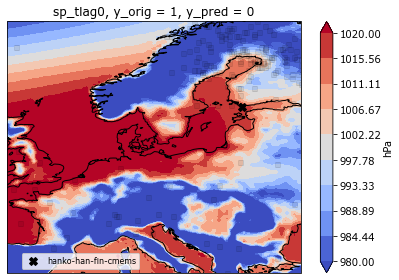

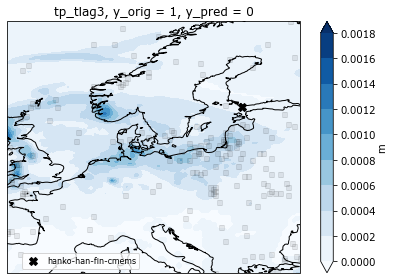

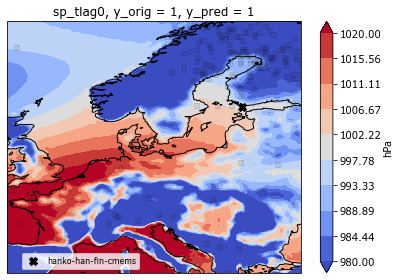

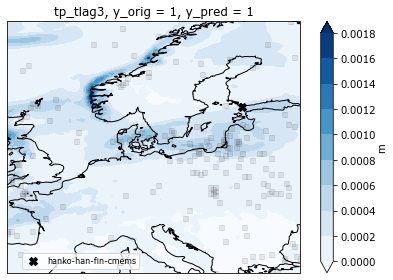

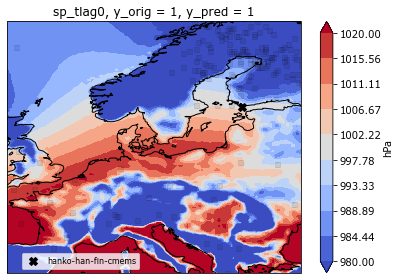

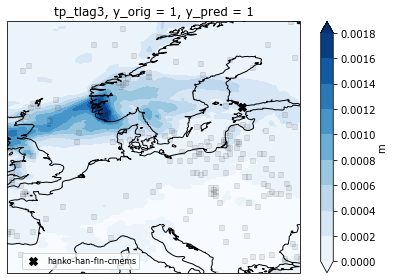

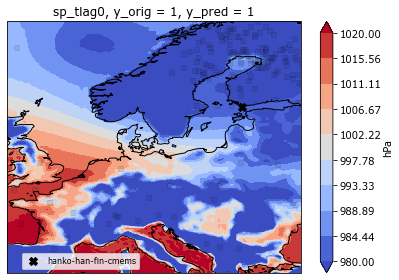

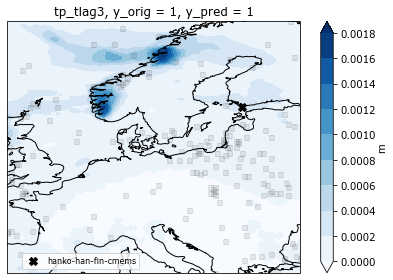

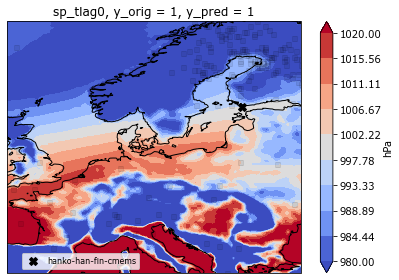

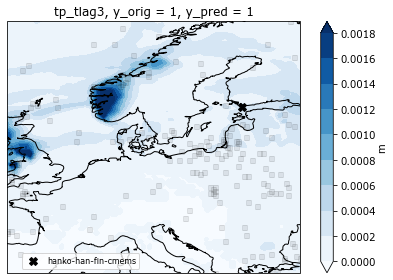

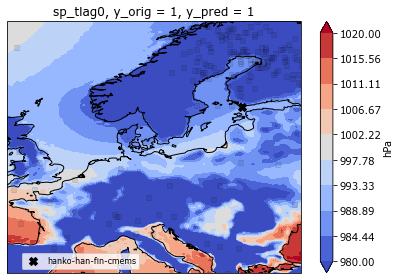

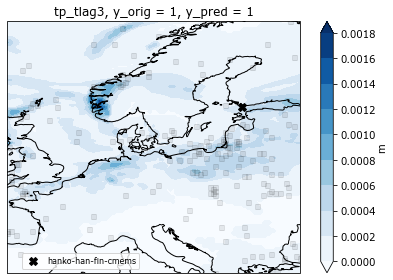

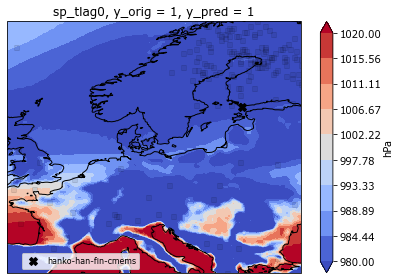

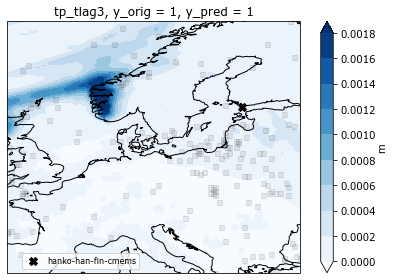

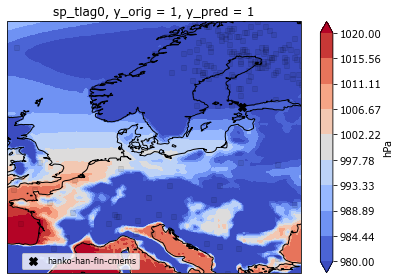

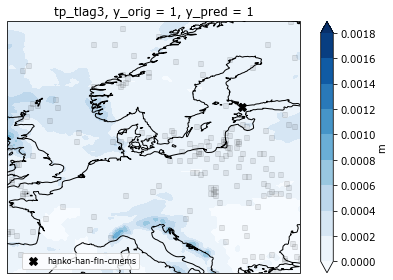

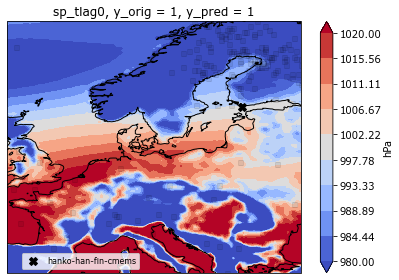

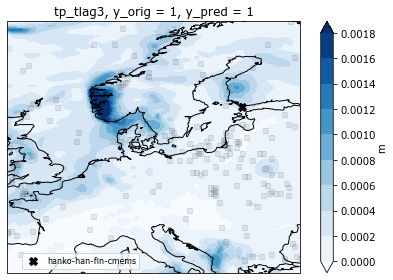

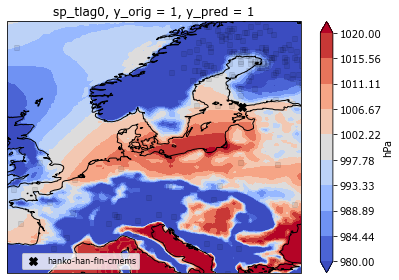

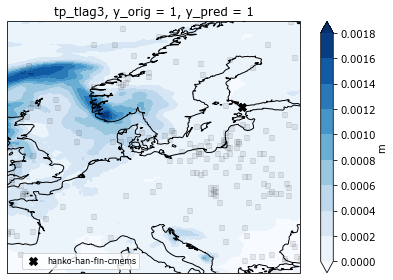

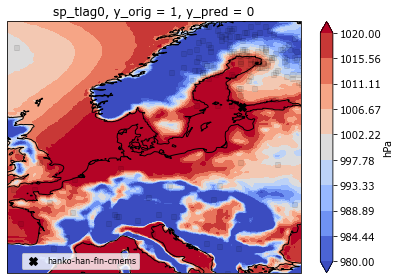

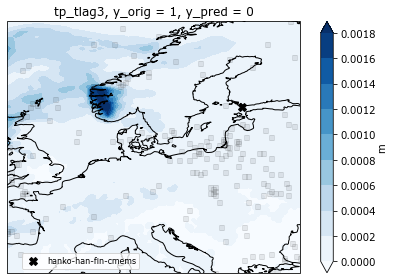

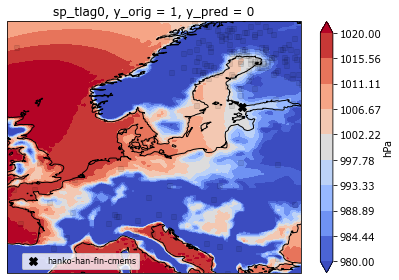

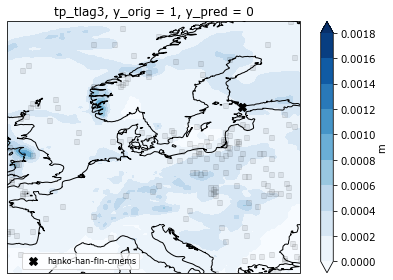

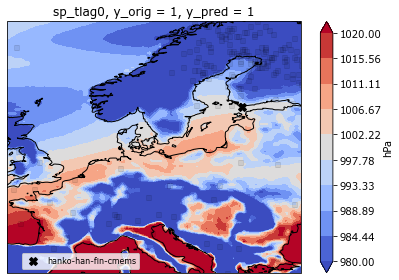

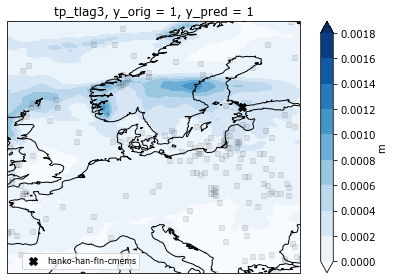

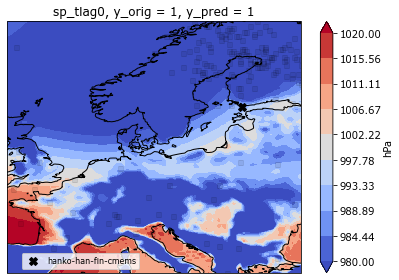

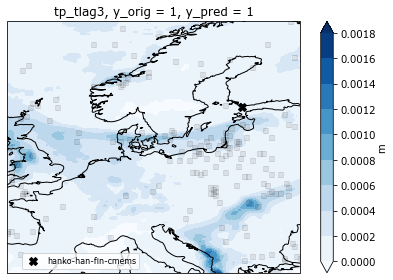

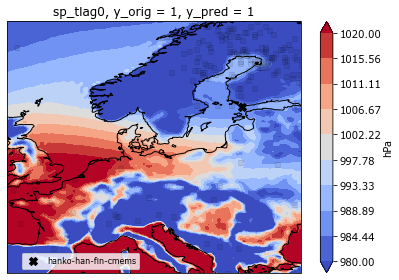

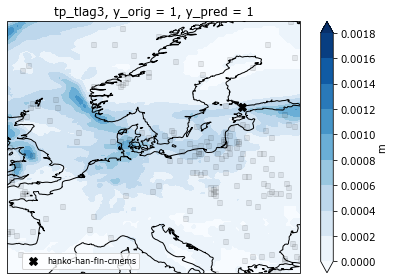

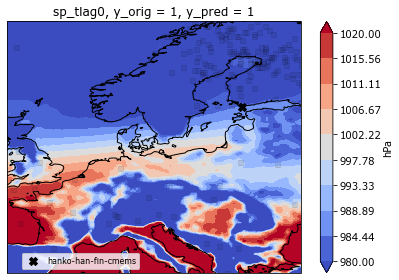

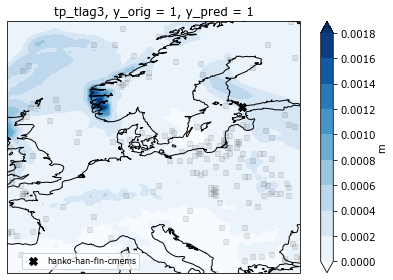

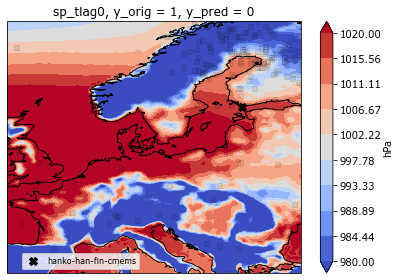

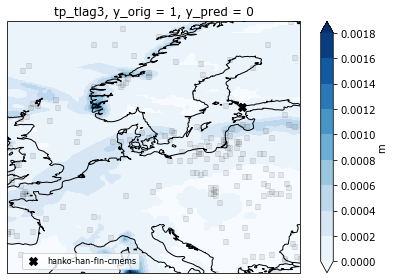

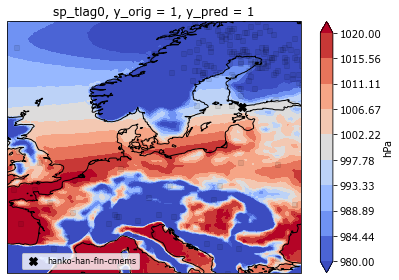

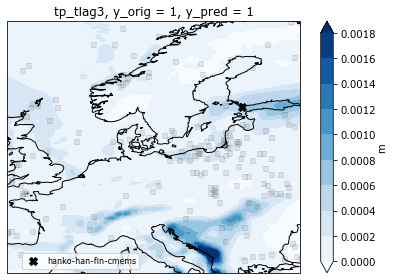

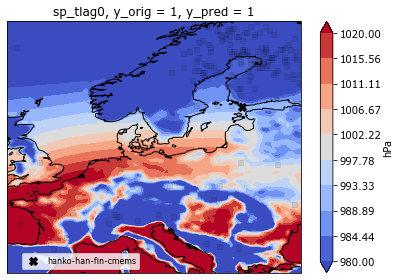

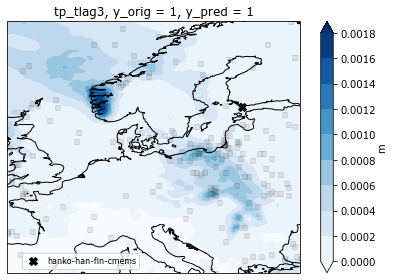

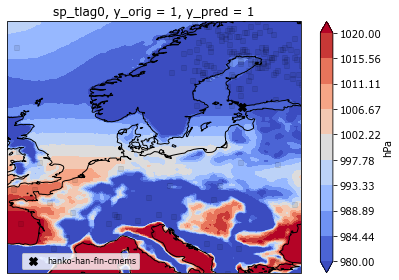

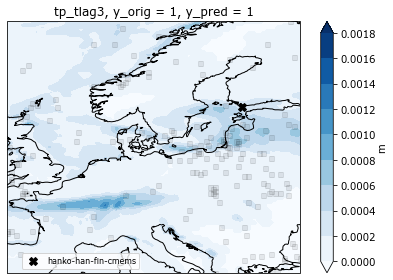

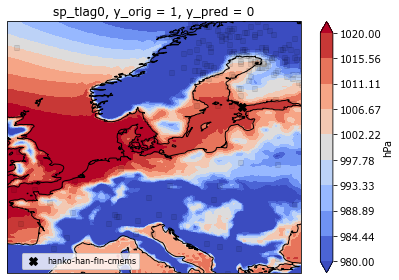

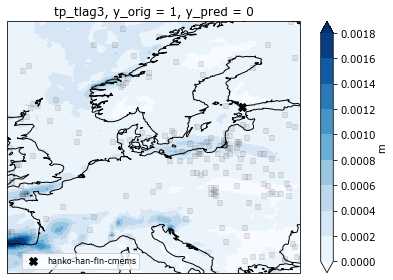

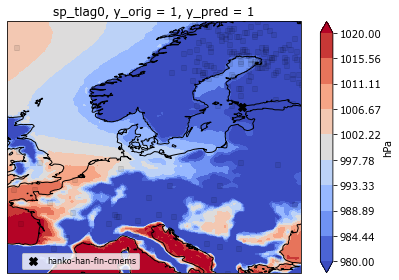

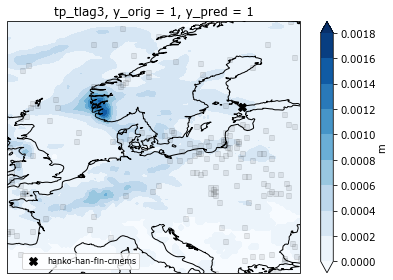

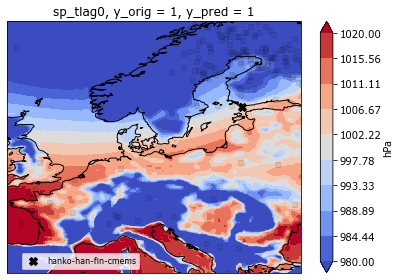

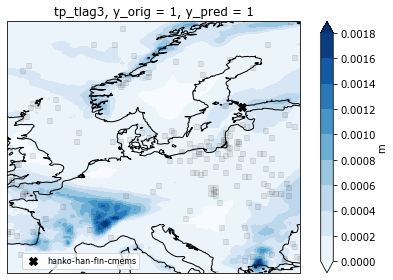

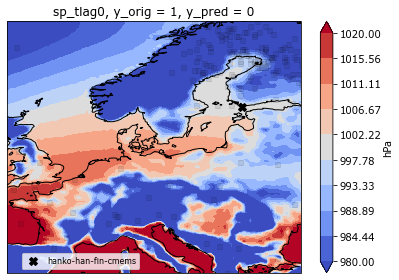

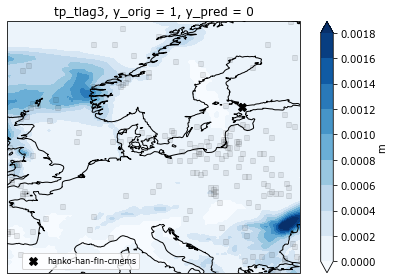

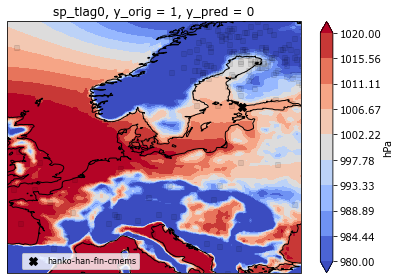

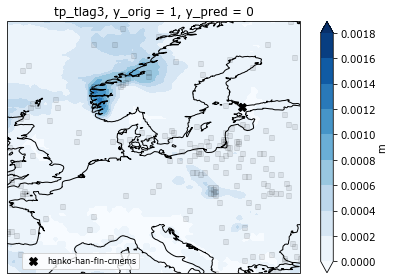

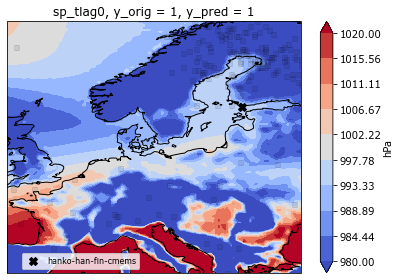

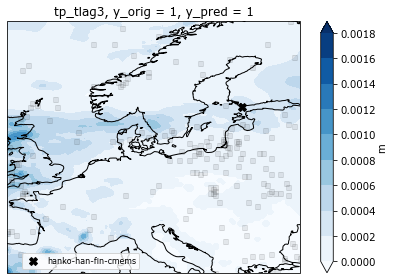

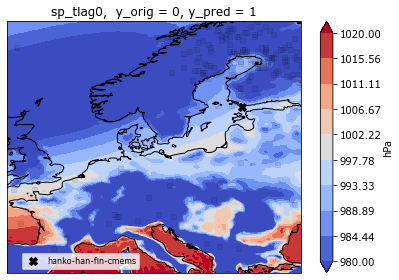

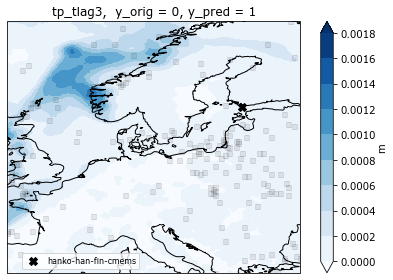

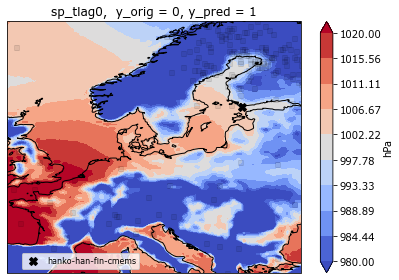

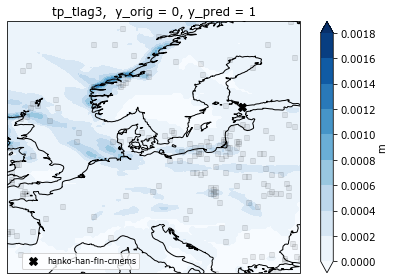

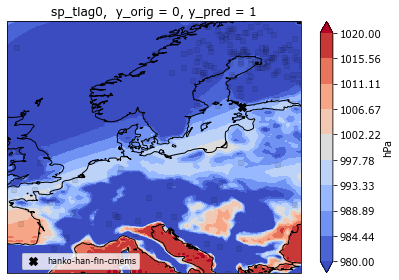

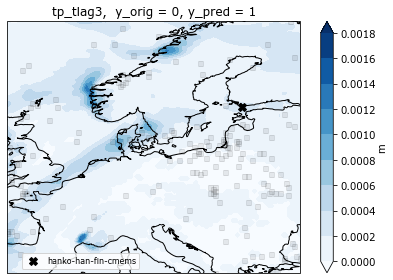

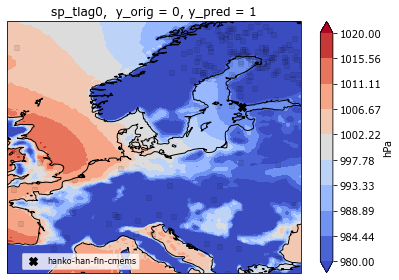

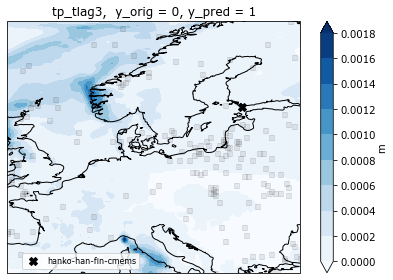

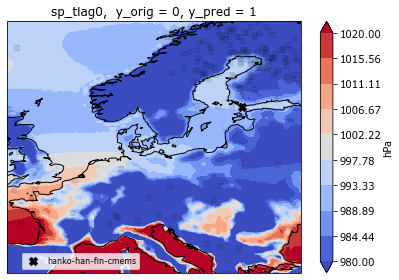

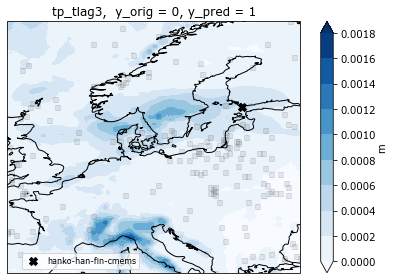

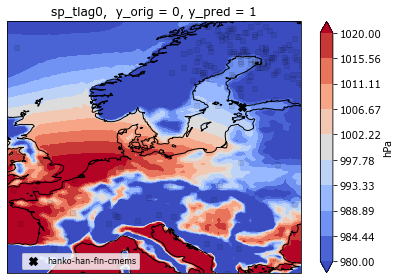

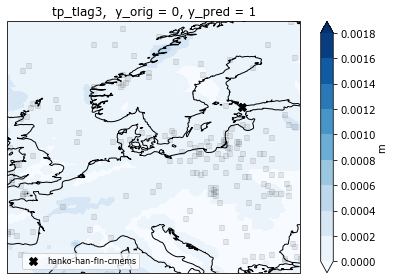

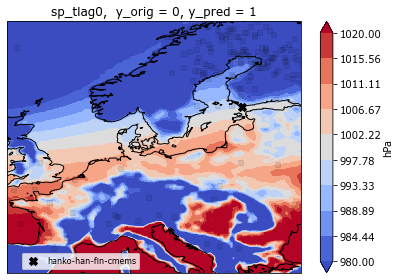

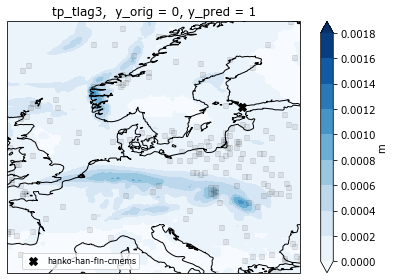

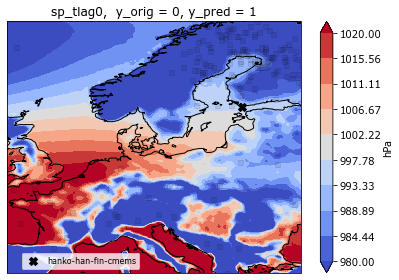

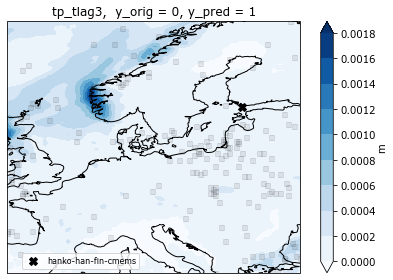

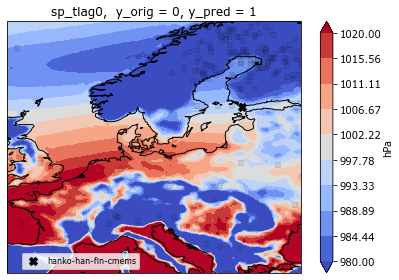

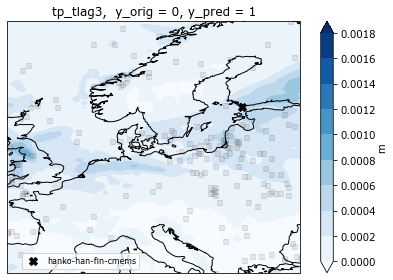

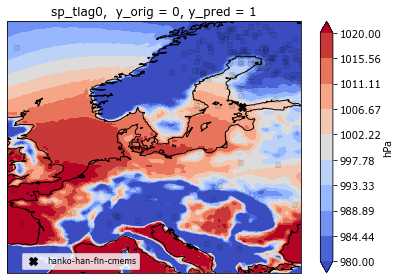

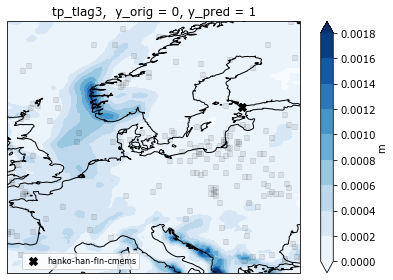

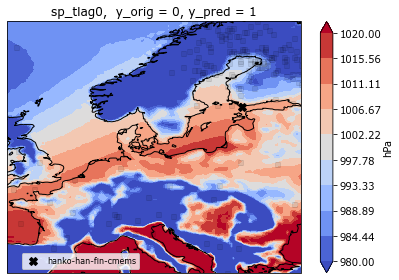

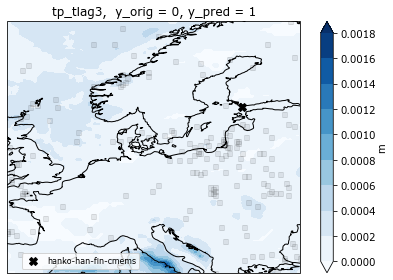

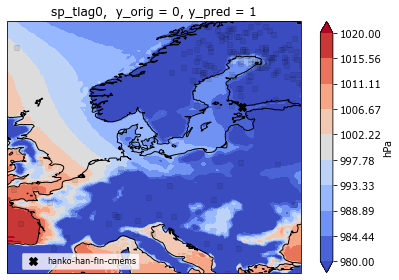

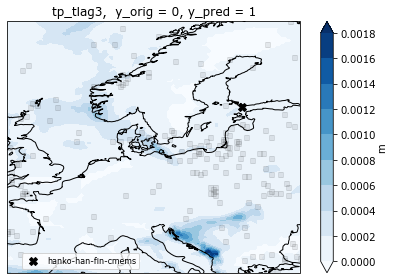

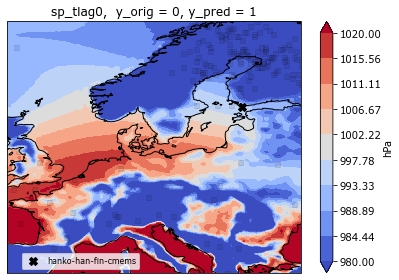

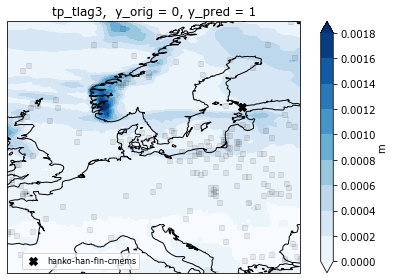

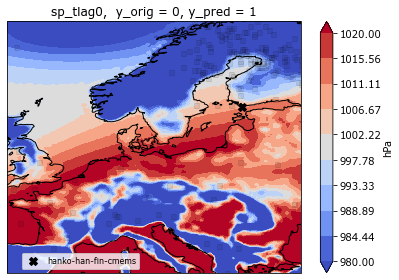

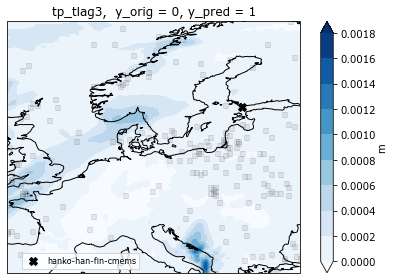

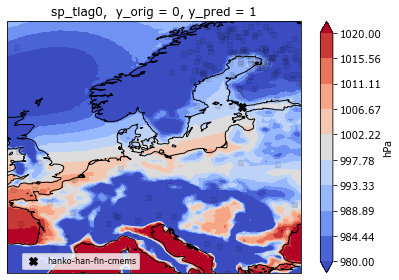

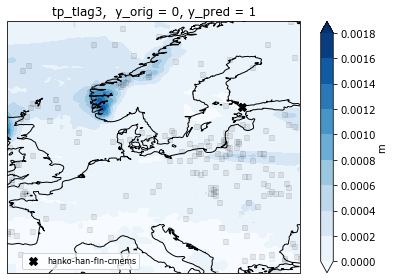

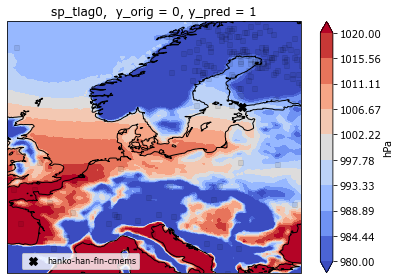

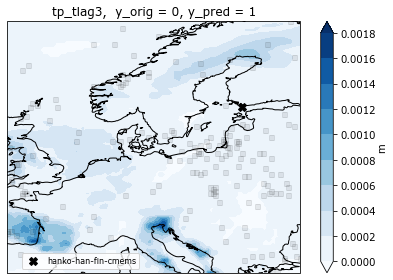

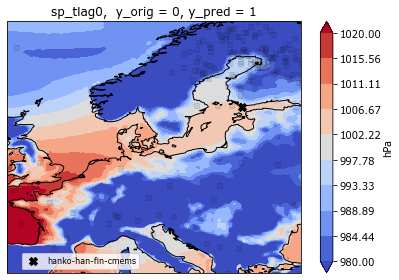

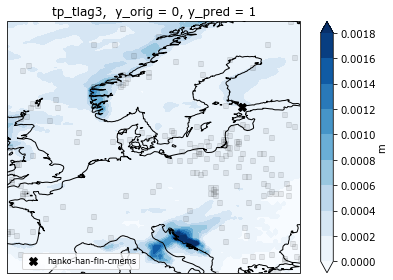

In [74]:
#---
# Plot Predictor Maps
#---
tic_predmap = time.perf_counter()

if era5_counter != 0: # Do not print predictor maps if only prefilling is used as predictor. Otherwise print predictor maps
        predictor_maps( # TODO: If only pf is used this should be skipped, e.g. no plotting of importance maps
                model, X_test, y_test,
                X_test_unscaled,
                ndim, n_pfs, is_pf_combined, # Needed to separate ERA5 importance from Prefilling importance
                lons, lats, pred_units, pred_names, 
                station_positions, station_names, is_station_name, 
                is_overlay_importance, 
                run_id, model_run, 
                percentile=99., markersize=5, alpha=0.08, color="k", colorbar_range=colorbar_range, nlevels=nlevels,
                )
toc_predmap = time.perf_counter()
time_predmap = toc_predmap - tic_predmap # Save time of this separately as it is not necessary for model predictions

In [75]:
#---
# Evaluate model / Diagnostic
#--- 
print("Evaluate Model \n")

# Score & Importance
#---
test_score = model.score(X_test, y_test)
train_score = model.score(X_train, y_train)
relative_score = evaluation.relative_scores(train_score, test_score)
importance = model.feature_importances_

# Save Scores & Importance
#---
folder = f"results/random_forest/{model_run}/"
saver.directory_existance(folder)

fname = f"importance_{str(percentile)[-2:]}_{run_id}"
np.save(f"{folder}{fname}", importance)
print(f"saved importance to : {folder}{fname}")

fname = f"testscore_{str(percentile)[-2:]}_{run_id}"
np.save(f"{folder}{fname}", test_score)
print(f"saved testscore to : {folder}{fname}")

fname = f"trainscore_{str(percentile)[-2:]}_{run_id}"
np.save(f"{folder}{fname}", train_score)
print(f"saved trainscore to : {folder}{fname}")

fname = f"relativescore_{str(percentile)[-2:]}_{run_id}"
np.save(f"{folder}{fname}", relative_score)
print(f"saved relativescore to : {folder}{fname}")

Evaluate Model 

testscore: 0.8933333333333333
trainscore: 0.9362962962962963
train/test: 1.0480928689883915
saved importance to : results/random_forest/rf015_test/importance_95_0
saved testscore to : results/random_forest/rf015_test/testscore_95_0
saved trainscore to : results/random_forest/rf015_test/trainscore_95_0
saved relativescore to : results/random_forest/rf015_test/relativescore_95_0


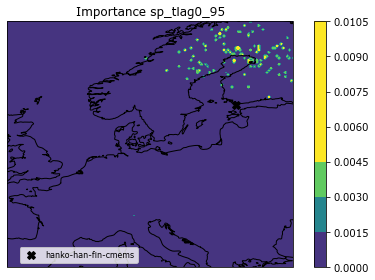

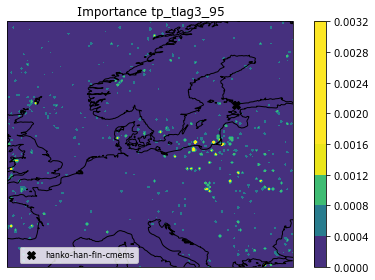

In [76]:

# Plot importance of each predictor from combination
# Goal:
# 1. Separate importance per predictor
# 2. Plot importance of each predictor on lon lat map
#---
n_pred_features = len(lons) * len(lats) # Features per predictor (lon/lat Input-Field). Needed for importance separation

if is_pf_combined:
    pf_importance = importance[-n_pfs:] 
    era5_importance = importance[:-n_pfs]
    predictor_importances = evaluation.separate_predictor_importance(era5_importance, n_pred_features) # Plot only importance map of era5 data
else:
    if era5_counter != 0: # Only plot predictor importance if at least one predictor is ERA5
        predictor_importances = evaluation.separate_predictor_importance(importance, n_pred_features)

for pred_idx, pred_importance in enumerate(predictor_importances): # TODO: If only pf is used this should be skipped, e.g. no plotting of importance maps
    # Plot importance map and save it
    predictor = pred_names[pred_idx] 
    tflag = f"{predictor}_{str(percentile)[-2:]}"
    
    if predictor == "pf": # Dont plot predictor importance if predictor is "pf"
        pass
    else: # Only plot predictor importance on map if predictor is ERA5
        fig, ax = evaluation.importance_map(pred_importance, lons, lats, tflag)

        # Add position of station to map
        #---
        for station_name in station_names:
            visualisation.plot_station(ax, station_positions, station_name, is_station_name)
            
        fname = f"importance_{predictor}_{str(percentile)[-2:]}_{run_id}"
        fig.savefig(f"{folder}{fname}.pdf")

Show Confusion Matrix on testdata 



C:\Users\Kai\AppData\Local\Temp\ipykernel_4876\3868347823.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig1.show()


Show Confusion Matrix on traindata 



C:\Users\Kai\AppData\Local\Temp\ipykernel_4876\3868347823.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig2.show()


saved cf matrix to : results/random_forest/rf015_test/testcf_matrix_95_0.pdf
saved cf matrix to : results/random_forest/rf015_test/traincf_matrix_95_0.pdf
Metric values 

tnr: 0.914572864321608
tpr: 0.7307692307692307
gmean: 0.8175216868944294
wacc: 0.8226710475454193
precision: 0.5277777777777778
recall: 0.7307692307692307
fmeasure: 0.6129032258064515
Metric values 

tnr: 0.9395509499136442
tpr: 0.9166666666666666
gmean: 0.9280382736831712
wacc: 0.9281088082901554
precision: 0.7154471544715447
recall: 0.9166666666666666
fmeasure: 0.8036529680365297
saved cf metrics to : traincf_metrics_95_0.pkl
Show AUROC 

AUC: 0.9118670274449169
saved AUROC to : results/random_forest/rf015_test/AUROC_95_0.pdf


C:\Users\Kai\AppData\Local\Temp\ipykernel_4876\3868347823.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


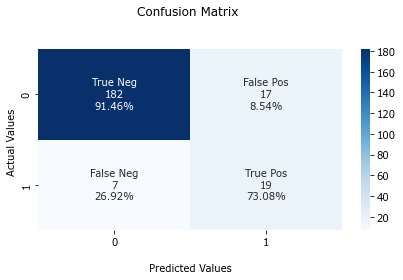

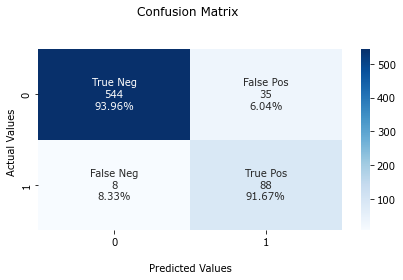

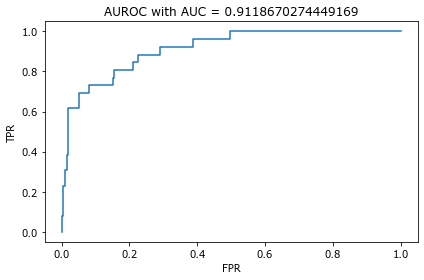

In [77]:
#---
# Confusion matrix
#---
# Format: 
# Reality / Model: Negative, Positive
# Negative    Right Negative, False Positive 
# Positive    False Negative, Right Positive

print("Show Confusion Matrix on testdata \n")
cfm_fig1 = evaluation.plot_cf(model, X_test, y_test)
cfm_fig1.show()

print("Show Confusion Matrix on traindata \n")
cfm_fig2 = evaluation.plot_cf(model, X_train, y_train)
cfm_fig2.show()

# Save CFM
fname = f"{folder}testcf_matrix_{str(percentile)[-2:]}_{run_id}.pdf"
cfm_fig1.savefig(fname)
print(f"saved cf matrix to : {fname}")

fname = f"{folder}traincf_matrix_{str(percentile)[-2:]}_{run_id}.pdf"
cfm_fig2.savefig(fname)
print(f"saved cf matrix to : {fname}")

# Calculate CFM-Metrics
metrics1 = evaluation.cfm_metrics(model, X_test, y_test)
metrics2 = evaluation.cfm_metrics(model, X_train, y_train)

fname = f"testcf_metrics_{str(percentile)[-2:]}_{run_id}.pkl"
with open(f"{folder}{fname}", 'wb') as f:
    pickle.dump(metrics1, f)

fname = f"traincf_metrics_{str(percentile)[-2:]}_{run_id}.pkl"
with open(f"{folder}{fname}", 'wb') as f:
    pickle.dump(metrics2, f)

print(f"saved cf metrics to : {fname}")

#---
# AUROC
# Receiver Operating Characteristics & Area Under the Curve
#---

print("Show AUROC \n")

y_test_proba = model.predict_proba(X_test)[:, 1] # Prob. for predicting 0 or 1, we only need second col

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

print(f'AUC: {auc}')

fig, ax = plt.subplots(tight_layout=True)

ax.plot(fpr, tpr)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title(f"AUROC with AUC = {auc}")

fig.show()

fname = f"{folder}AUROC_{str(percentile)[-2:]}_{run_id}.pdf"
fig.savefig(fname)
print(f"saved AUROC to : {fname}")

In [78]:
gesla_predictand["date_time"].values[97458]

numpy.datetime64('2016-01-04T06:00:00.000000000')

Add predictor sp to model input features
timeseries is already of dtype datetime64[ns]
Converted units of sp from Pa to hPa
Get overlapping timeseries of ERA5 and GESLA
date:2016-01-01 at position [631] was deleted as it was in predictor data but not in predictand data
date:2016-01-02 at position [631] was deleted as it was in predictor data but not in predictand data
date:2016-01-03 at position [631] was deleted as it was in predictor data but not in predictand data
Introduce timelag: 0 for sp
with shape (899, 121, 141)
Add predictor tp to model input features
timeseries is already of dtype datetime64[ns]
Get overlapping timeseries of ERA5 and GESLA
date:2016-01-01 at position [631] was deleted as it was in predictor data but not in predictand data
date:2016-01-02 at position [631] was deleted as it was in predictor data but not in predictand data
date:2016-01-03 at position [631] was deleted as it was in predictor data but not in predictand data
Introduce timelag: 3 for tp
with shape

C:\Users\Kai\AppData\Local\Temp\ipykernel_4876\2536564830.py:157: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


saved cf matrix to : results/random_forest/rf015_test/unknowncf_matrix_95_0.pdf
Metric values 

tnr: 1.0
tpr: 0.0
gmean: 0.0
wacc: 0.5
precision: nan
recall: 0.0
fmeasure: nan
{'tnr': 1.0, 'tpr': 0.0, 'gmean': 0.0, 'wacc': 0.5, 'precision': nan, 'recall': 0.0, 'fmeasure': nan}


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\evaluation.py:184: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)


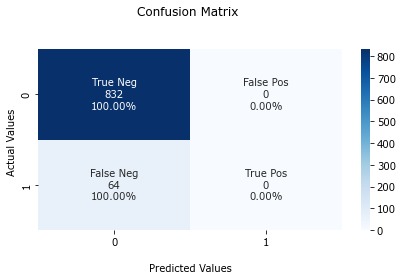

In [79]:
#---
# Test on data completely unknown to model
# TODO: This can also be done if pf is in predictors and is_pf_combined is switched on. Then I need to load predictor values as before.
#---
# Initialize
#---

X = []
Y = []
t = []

# Load unknown data
#---
era5_counter = 0
for pred_idx, predictor in enumerate(predictors):
    print(f"Add predictor {predictor} to model input features")

    # Load data of predictor
    #---
    import xarray as xr
    if predictor == "pf":
        is_prefilled = True

        era5_predictor = data_loader.load_pf(season)

        if is_pf_combined:
            # Set predictand to degerby proxy with intersected time. Timescale is reduced from hourly to daily like ERA5
            era5_predictor_tmp = data_loader.load_daymean_era5(unknown_range_of_years, subregion, season, predictors[era5_counter-1], preprocess) # Load any ERA5 predictor that is in combination
            era5_predictor_tmp = preprocessing.convert_timestamp(era5_predictor_tmp, dim="time")
            tmp, era5_predictor, tmp = preprocessing.intersect_time(era5_predictor_tmp, era5_predictor, is_prefilling=False) # Reduces hourly data at Degerby to daily data (max per day of sea level is chosen)
            
            tmp, Y_, t_ = preprocessing.intersect_time(era5_predictor_tmp, gesla_predictand, is_prefilling=False)
            
            X_ = era5_predictor 

            del tmp, era5_predictor_tmp
        else:
            # If pf is used without any ERA5 data, use hourly data of Degerby.
            X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand, is_prefilled) 
        
    else:
        is_prefilled = False
        era5_counter = era5_counter + 1
        era5_predictor = data_loader.load_daymean_era5(unknown_range_of_years, subregion, season, predictor, preprocess)
        era5_predictor = preprocessing.convert_timestamp(era5_predictor, dim="time")

        # Convert predictor sp.unit from Pa to hPA
        #---
        if predictor == "sp":
            with xr.set_options(keep_attrs=True):
                old_unit = era5_predictor.attrs["units"]
                era5_predictor = era5_predictor / 100
                era5_predictor.attrs["units"] = "hPa"
                new_unit = era5_predictor.attrs["units"]
                print(f"Converted units of {predictor} from {old_unit} to {new_unit}")
        
        X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand, is_prefilled)

    #---
    # Get timelags
    #---
    print(f"Introduce timelag: {timelags[pred_idx]} for {predictor}")

    print(f"with shape {X_.shape}")
    X_timelag, Y_timelag = preprocessing.add_timelag(X_, Y_, timelags, pred_idx) 

    X.append(X_timelag)
    Y.append(Y_timelag)
    t.append(t_)

#--- 
# Convert to format needed for model fit
#---
if is_pf_combined:
    Y = np.array(Y) 
    Y = Y[0, :] # Assume all timeseries are the same for the predictors.
    ndim = Y.shape[0]
    max_length = len(X)
    n_pfs = max_length - era5_counter # Number of prefilling predictors

    print(era5_counter, max_length, n_pfs, ndim)

    era5_x = np.array(X[:era5_counter])
    era5_x = era5_x.swapaxes(0, 1)
    era5_x = era5_x.reshape(ndim, -1)

    print(f"ERA5 shape: {era5_x.shape}")

    #--- 
    # Insert prefilling data at the beginning
    #---
    XX = era5_x
    for i in range(era5_counter, max_length):
        print(f"Add Predictor {pred_names[i]} to end of X")
        XX = np.append(XX, X[i], axis=1)


    y = Y[:, 0] # Select one station

    #---
    # Handle NaN Values
    #---

    # Insert numerical value that is not in data.
    # ML will hopefully recognize it.
    XX[np.where(np.isnan(XX))] = -999

    X = XX
    
    del XX
    print("Data is prepared as follows")
    print(f"X.shape : {X.shape}")
    print(f"y.shape : {y.shape}")
    print(f"pred_names : {pred_names}")
    print(f"pred_units : {pred_units}")
else:
    # Convert to format needed for model fit
    #---      
    X = np.array(X)
    Y = np.array(Y) 
    Y = Y[0, :] # Assume all timeseries are the same for the predictors.
    t = np.array(t)

    # Reshape for model input
    #---
    print(f"Reshape for model input")

    ndim = Y.shape[0]

    X = X.swapaxes(0, 1) # Put time dimension to front

    print(X.shape) # (time, timelags, predictor_combination, lon?, lat?)

    X = X.reshape(ndim, -1) # Reshapes into (time, pred1_lonlats:pred2_lonlats:...:predn_lonlats)
    y = Y[:, 0] # Select one station

    #---
    # Handle NaN Values
    #---

    # Insert numerical value that is not in data.
    # ML will hopefully recognize it.
    X[np.where(np.isnan(X))] = -999

    print("Data is prepared as follows")
    print(f"X.shape : {X.shape}")
    print(f"y.shape : {y.shape}")
    print(f"pred_names : {pred_names}")
    print(f"pred_units : {pred_units}")

# Evaluate Prediction on unknown data
#---
print("Show Confusion Matrix on unknown testdata \n")
cfm_fig = evaluation.plot_cf(model, X, y)
cfm_fig.show()

# Save CFM
fname = f"{folder}unknowncf_matrix_{str(percentile)[-2:]}_{run_id}.pdf"
cfm_fig.savefig(fname)
print(f"saved cf matrix to : {fname}")

# Calculate CFM-Metrics
metrics = evaluation.cfm_metrics(model, X, y)
print(metrics)
fname = f"unknowncf_metrics_{str(percentile)[-2:]}_{run_id}.pkl"
with open(f"{folder}{fname}", 'wb') as f:
    pickle.dump(metrics, f)

# Work Area

- [ ]  **Make it able to combine prefilling and other predictors**
    - [done]  Watch out for timelag! (in hours instead of daily)
    - Intersection leads to a reduction from hourly data to daily data. Daily max sea level of degerby is then chosen.

In [15]:
preprocess = "preprocess1" # ["preprocess1"]
range_of_years = "1999-2008" # ["1999-2008", "2009-2018", "2019-2022",] 
unknown_range_of_years = "2009-2018"
subregion = "lon-0530_lat7040" # ["lon-0530_lat7040"]

In [16]:
# Load Predictand
#---
gesla_predictand = data_loader.load_gesla(station_names)

# Get lon/lat positions of stations
#---
station_positions = gesla_preprocessing.station_position(gesla_predictand, station_names)

# Select a season
#---
gesla_predictand = gesla_preprocessing.select_season(gesla_predictand, season)

# Select only sea_level analysis data
#---
gesla_predictand = gesla_preprocessing.get_analysis(gesla_predictand)
gesla_predictand = gesla_predictand["sea_level"] # Select values

# Detrend 
#---
gesla_predictand = gesla_preprocessing.detrend_signal(gesla_predictand, type_=detrend_type) 

# Apply one hot encoding
#---
gesla_predictand = gesla_preprocessing.apply_dummies(gesla_predictand, percentile=percentile, level="station")
print(f"Applied one-hot-encoding with Percentile: {percentile}")

# Convert to DataArray
# nan values: no measurement at that timestamp for specific station
#---
gesla_predictand = gesla_predictand.to_xarray()

In [15]:
#---
# Load ERA5- Predictor
#---

# Initialize
#---
predictors = ["sp", "tp", "pf"]
timelags = [0, 3, 2,] # Needs to be in hours if is_pf_combined = False
is_pf_combined = True
X = []
Y = []
t = []
pred_units = []
pred_names = []

# Main
#---
era5_counter = 0
for pred_idx, predictor in enumerate(predictors):
    print(f"Add predictor {predictor} to model input features")

    # Load data of predictor
    #---
    import xarray as xr
    if predictor == "pf":
        is_prefilled = True

        era5_predictor = data_loader.load_pf(season)

        if is_pf_combined:
            # Set predictand to degerby proxy with intersected time. Timescale is reduced from hourly to daily like ERA5
            era5_predictor_tmp = data_loader.load_daymean_era5(range_of_years, subregion, season, predictors[era5_counter-1], preprocess) # Load any ERA5 predictor that is in combination
            era5_predictor_tmp = preprocessing.convert_timestamp(era5_predictor_tmp, dim="time")
            tmp, era5_predictor, tmp = preprocessing.intersect_time(era5_predictor_tmp, era5_predictor, is_prefilling=False) # Reduces hourly data at Degerby to daily data (max per day of sea level is chosen)
            
            tmp, Y_, t_ = preprocessing.intersect_time(era5_predictor_tmp, gesla_predictand, is_prefilling=False)
            
            X_ = era5_predictor 
            del tmp, era5_predictor_tmp
        else:
            # If pf is used without any ERA5 data, use hourly data of Degerby.
            X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand, is_prefilled) 
        
    else:
        is_prefilled = False
        era5_counter = era5_counter + 1
        era5_predictor = data_loader.load_daymean_era5(range_of_years, subregion, season, predictor, preprocess)
        era5_predictor = preprocessing.convert_timestamp(era5_predictor, dim="time")
        
        X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand, is_prefilled)

    # Convert predictor sp.unit from Pa to hPA
    #---
    if predictor == "sp":
        with xr.set_options(keep_attrs=True):
            old_unit = era5_predictor.attrs["units"]
            era5_predictor = era5_predictor / 100
            era5_predictor.attrs["units"] = "hPa"
            new_unit = era5_predictor.attrs["units"]
            print(f"Converted units of {predictor} from {old_unit} to {new_unit}")
    #---
    # Get timelags
    #---
    print(f"Introduce timelag: {timelags[pred_idx]} for {predictor}")

    X_timelag, Y_timelag = preprocessing.add_timelag(X_, Y_, timelags, pred_idx) 

    X.append(X_timelag)
    Y.append(Y_timelag)
    t.append(t_)

    # # Save unit and name of predictor
    # #---
    if predictor == "pf":
        pred_units.append("m")
        if is_pf_combined:
            pred_names.append(f"{predictor}_tlag{timelags[pred_idx]}") # Daily values of timelags if is_pf_combined
        else:
            pred_names.append(f"{predictor}_tlag{timelags[pred_idx] // 24}") # Hourly values converted back to daily values for interpretation
    else:
        pred_units.append(era5_predictor.units)
        pred_names.append(f"{era5_predictor.name}_tlag{timelags[pred_idx]}")
        
#---
# Convert ERA5 Data to shape of train test split
#---

if is_pf_combined:
    Y = np.array(Y) 
    Y = Y[0, :] # Assume all timeseries are the same for the predictors.
    ndim = Y.shape[0]
    max_length = len(X)
    n_pfs = max_length - era5_counter # Number of prefilling predictors

    print(era5_counter, max_length, n_pfs, ndim)

    era5_x = np.array(X[:era5_counter])
    era5_x = era5_x.swapaxes(0, 1)
    era5_x = era5_x.reshape(ndim, -1)

    print(f"ERA5 shape: {era5_x.shape}")

    #--- 
    # Insert prefilling data at the beginning
    #---
    XX = era5_x
    new_names = pred_names
    new_units = pred_units
    for i in range(max_length-1, era5_counter-1, -1): # Insert last indicated prefilling at the beginning first, s.t. the first indicated prefilling appears also first in the final array
        print(f"Add Predictor {pred_names[i]} to beginning of X")
        XX = np.insert(XX, 0, X[i], axis=1)
        new_names = np.insert(np.array(new_names), 0, pred_names[i], axis=0)
        new_names = np.delete(new_names, -1, axis=0)
        new_units = np.insert(np.array(new_units), 0, pred_units[i], axis=0)
        new_units = np.delete(new_units, -1, axis=0)


    y = Y[:, 0] # Select one station

    #---
    # Handle NaN Values
    #---

    # Insert numerical value that is not in data.
    # ML will hopefully recognize it.
    XX[np.where(np.isnan(XX))] = -999

    print("Data is prepared as follows")
    print(f"X.shape : {XX.shape}")
    print(f"y.shape : {y.shape}")
    print(f"pred_names : {pred_names}")
    print(f"pred_units : {pred_units}")
    print(f"new_names : {new_names}")
    print(f"new_units : {new_units}")

else:
    # Old Way
    pass

Add predictor sp to model input features
timeseries is already of dtype datetime64[ns]
Get overlapping timeseries of ERA5 and GESLA
Converted units of sp from Pa to hPa
Introduce timelag: 0 for sp
Add predictor tp to model input features
timeseries is already of dtype datetime64[ns]
Get overlapping timeseries of ERA5 and GESLA
Introduce timelag: 3 for tp
Add predictor pf to model input features
Load Predictand from GESLA
timeseries is already of dtype datetime64[ns]
Get overlapping timeseries of ERA5 and GESLA
Get overlapping timeseries of ERA5 and GESLA
Introduce timelag: 2 for pf
Add predictor pf to model input features
Load Predictand from GESLA
timeseries is already of dtype datetime64[ns]
Get overlapping timeseries of ERA5 and GESLA
Get overlapping timeseries of ERA5 and GESLA
Introduce timelag: 1 for pf
2 4 2 900
ERA5 shape: (900, 34122)
Add Predictor pf_tlag1 to beginning of X
Add Predictor pf_tlag2 to beginning of X
Data is prepared as follows
X.shape : (900, 35922)
y.shape : (

In [16]:
#---
# Apply Train-Test split 
#---
print("Apply train-test-split")
X_train, X_test, y_train, y_test = train_test_split(XX, y, random_state=random_state, test_size=test_size)

if is_scaled:
    print("Scale training data")
    s = StandardScaler()
    s.fit(X_train)
    X_train = s.transform(X_train)
    X_test = s.transform(X_test)

#---
#  Optimize Hyperparameters
#---
if is_optimized:
    print(f"Optimize Hyperparameters using {optimizer}")
    print(f"Tested Hyperparameters: {hparam_grid}")
    
    hparam_grid_opt = modelfit.optimize_hyperparameter(X_train, y_train, clf(), optimizer, hparam_grid, k, n_iter, n_jobs=-1)

if not is_optimized:
    model_path = models_path[idx]
    print(f"Hyperparameters are loaded from model: {model_path}")
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    hparam_grid_opt = model.get_params()
    
#---
#  Save hyperparameters
#---
folder = f"models/random_forest/{model_run}/" 
saver.directory_existance(folder)
saver.save_hpdict(hparam_grid_opt, run_id, model_run, percentile, folder)

print("Saved Hyperparameters")

#---
# Fit the model
#---
print(f"Fit model with hyperparameters {hparam_grid_opt}")

model = clf(**hparam_grid_opt) # One can set parameters afterwards via model.set_params() 

model.fit(X_train, y_train)

#---
# Saving the model
#---
print("Save model")
filename = f'{model_run}_{optimizer}_{run_id}.sav'
pickle.dump(model, open(f'{folder}{filename}', 'wb'))

Apply train-test-split
Scale training data
Optimize Hyperparameters using RandomSearchCV
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [1, 2, 3, 4], 'criterion': ['gini'], 'random_state': [0], 'class_weight': ['balanced'], 'oob_score': [True]}


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 40 is smaller than n_iter=100. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 40 candidates, totalling 120 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

Created directory: models/random_forest/rf015_test/
File saved to: models/random_forest/rf015_test/rf015_test_095.pkl
Saved Hyperparameters
Fit model with hyperparameters {'random_state': 0, 'oob_score': True, 'n_estimators': 111, 'max_depth': 4, 'criterion': 'gini', 'class_weight': 'balanced'}
Save model


In [31]:
def predictor_maps(model, X_test, y_test, ndim, n_pfs, is_pf_combined, lons, lats, pred_units, pred_names, station_positions, station_names, is_station_name, is_overlay_importance, run_id, model_run, percentile, markersize, alpha, color, colorbar_range, nlevels=10):
    """
    Description:
        Plots values of all predictors used for model training. Selects timepoints where Storm Surges were in original data and indicates whether 
        the prediction was true or not in the filename ("isfalse", "istrue"). The file naming "predss" is for situations, where a storm surge was predicted
        but the original data has no storm surge.
    Parameters:
        model (clf): Model that was fitted to X_test, y_test.
        X_test (): Test set of predictor data used for model fit
        y_test (): Test set of predictand data used for model fit
        lons (): Values of longitudes of predictors
        lats (): Values of latitudes of predictors
        pred_units (list): Units of all predictors used, e.g. ms**-1
        pred_names (list): Names of all predictors used, e.g. sp_tlag0
        station_positions (dict,): Dicitionary with station name (key) and a list of [lon, lat] (values)
        station_name (str): Name of the station given in GESLA dataset.
        is_station_name (bool): Whether to indicate station name in plot or not (Defaults: False)
        is_overlay_importance (bool): Overlay values of importance of that predictor or not
        run_id (int): Number of the model run
        model_run (str): Name of the current model run
        percentile (float): Percentile (0-100) for selecting position of overlayed importance
        markersize (int): Size of square-marked positions of importance
        alpha (float): Transparency of square-markers for importance
        color (str): Color of square-marker for importance
        colorbar_range (dict): Keys are predictors (e.g. "sp"), values are list of [vmin, vmax] values for colorbar
        nlevels (int): Number of levels in contour plot (e.g. sections of the colorbar) (Defaults: 10)

    Returns:
        None
    """
    #---
    # Make a prediction
    #---
    nlat = lats.size
    nlon = lons.size
    y_test_pred = model.predict(X_test) # Predicted data
    importance = model.feature_importances_
    n_pred_features = nlon * nlat # Features per predictor (lon/lat Input-Field). Needed for importance separation

    # Get importance per predictor of model
    #---
    if is_pf_combined:
        era5_importance = importance[n_pfs * ndim:] # Select only values that contain era5 as predictor
        X_test = X_test[:, n_pfs * ndim:]

    predictor_importances = evaluation.separate_predictor_importance(era5_importance, n_pred_features) #

    #---
    # Select data for plotting original storm surge events
    #---
    ss_idx = np.where(y_test == 1) # Timepoints of storm surges in original data

    y_test_ss = y_test[ss_idx] # Original data storm surges only
    y_pred_ss = y_test_pred[ss_idx] # Predictions at timepoints of SS in original data

    ntime = X_test.shape[0]
    X_pred = X_test.reshape(ntime, -1, nlat, nlon) # Reshape to fit format for plotting predictor values on a map

    X_pred_plot = X_pred[ss_idx] # Select only predictor values at timepoints of storm surges

    #---
    # Plot & Save predictor map at original storm surge events
    #---
    n_time = X_pred_plot.shape[0]
    n_pred = X_pred_plot.shape[1]

    time_idx = 0
    for time in range(n_time):

        is_correct_prediction = (y_test_ss[time] == y_pred_ss[time])

        for pred_idx in range(n_pred):
            pred_flag = pred_names[pred_idx].split("_")[0] # Split because string is "tp_tlag0" etc.
            # Convert unit of colorbar
            #---
            unit = pred_units[pred_idx]
            if (unit == "m s**-1"): 
                unit = "m/s"

            # Create Figure
            #---
            data = X_pred_plot[time, pred_idx, :, :].flatten() # Predictor data

            if is_correct_prediction:
                tflag = f"{pred_names[pred_idx]}, y_orig = 1, y_pred = 1"
                fname = f"{pred_names[pred_idx]}_{time_idx}_istrue_{run_id}"
            else:
                tflag = f"{pred_names[pred_idx]}, y_orig = 1, y_pred = 0" 
                fname = f"{pred_names[pred_idx]}_{time_idx}_isfalse_{run_id}"
            
            # Get colorbar vmin vmax
            #---
            vmin = colorbar_range[pred_flag][0] 
            vmax = colorbar_range[pred_flag][1]

            # Choose colormap
            #---
            if pred_flag == "sp":
                cmap = "coolwarm"
            elif pred_flag == "tp":
                cmap = "Blues"
            elif (pred_flag == "u10" or pred_flag == "v10"):
                cmap= "seismic"

            # Plot figure
            #---
            fig, ax = map(data, lons, lats, tflag=tflag, unit=unit, vmin=vmin, vmax=vmax, nlevels=nlevels, cmap=cmap)
            
            # Add position of station to map
            #---
            for station_name in station_names:
                plot_station(ax, station_positions, station_name, is_station_name)

            # Add importance to map
            #---
            if is_overlay_importance:
                pred_importance = predictor_importances[pred_idx]
                evaluation.overlay_importance(ax, pred_importance, lats, lons, percentile=percentile, alpha=alpha, markersize=markersize, color=color)

            # Save plot
            #---
            folder1 = f"results/random_forest/{model_run}/predictor_maps/"
            saver.directory_existance(folder1)

            fig.savefig(f"{folder1}{fname}.pdf")

        time_idx = time_idx + 1

    #---
    # Plot & Save predictor map of predicted storm surge events where original data has no storm surge 
    #---
    idx2 = np.where(y_test_pred == 1) # Select all occurences where prediction has SS
    y_test_idx2 = y_test[idx2]
    X_pred_plot = X_pred[idx2]
    idx3 = np.where(y_test_idx2 == 0) # Subselect all occurences where prediction has SS and original data has no SS
    X_pred_plot = X_pred_plot[idx3] # Choose this selection as a plot
    n_time = X_pred_plot.shape[0]
    n_pred = X_pred_plot.shape[1]

    for time in range(n_time):
        for pred_idx in range(n_pred):
            pred_flag = pred_names[pred_idx].split("_")[0] # Split because string is "tp_tlag0" etc.
            # Convert unit of colorbar
            #---
            unit = pred_units[pred_idx]
            if (unit == "m s**-1"): 
                unit = "m/s"

            # Create Figure
            #---
            data = X_pred_plot[time, pred_idx, :, :].flatten() # Predictor data

            tflag = f"{pred_names[pred_idx]},  y_orig = 0, y_pred = 1"
            
            # Get colorbar vmin vmax
            #---
            vmin = colorbar_range[pred_flag][0] # Split because string is "tp_tlag0" etc.
            vmax = colorbar_range[pred_flag][1]

            # Choose colormap
            #---
            if pred_flag == "sp":
                cmap = "coolwarm"
            elif pred_flag == "tp":
                cmap = "Blues"
            elif (pred_flag == "u10" or pred_flag == "v10"):
                cmap= "seismic"
                
            # Plot figure
            #---
            fig, ax = map(data, lons, lats, tflag=tflag, unit=unit, vmin=vmin, vmax=vmax, nlevels=nlevels, cmap=cmap)

            # Add position of station to plot
            #---
            for station_name in station_names:
                plot_station(ax, station_positions, station_name, is_station_name)

            # Add importance to map
            if is_overlay_importance:
                pred_importance = predictor_importances[pred_idx]
                evaluation.overlay_importance(ax, pred_importance, lats, lons, percentile=percentile, alpha=alpha, markersize=markersize, color=color)
            
            # Save figure
            #---
            folder1 = f"results/random_forest/{model_run}/predictor_maps/"
            saver.directory_existance(folder1)

            fname = f"{pred_names[pred_idx]}_{time_idx}_predss_{run_id}"

            fig.savefig(f"{folder1}{fname}.pdf")

        time_idx = time_idx + 1

In [ ]:
#---
# Plot Predictor Maps
#---
tic_predmap = time.perf_counter()
if "pf" in predictors:
    pass
else:
    visualisation.predictor_maps(
        model, X_test, y_test,
        ndim, n_pfs, is_pf_combined, 
        lons, lats, pred_units, pred_names, 
        station_positions, station_names, is_station_name, 
        is_overlay_importance, 
        run_id, model_run, 
        percentile=99., markersize=5, alpha=0.08, color="k", colorbar_range=colorbar_range, nlevels=nlevels,
        )
toc_predmap = time.perf_counter()
time_predmap = toc_predmap - tic_predmap # Save time of this separately as it is not necessary for model predictions

In [27]:
#---
# Evaluate model / Diagnostic
#--- 
print("Evaluate Model \n")

# Score & Importance
#---
test_score = model.score(X_test, y_test)
train_score = model.score(X_train, y_train)
relative_score = evaluation.relative_scores(train_score, test_score)
importance = model.feature_importances_
pf_importance = importance[:n_pfs * ndim] # TODO: Save them separately?
era5_importance = importance[n_pfs * ndim:]

Evaluate Model 

testscore: 0.8666666666666667
trainscore: 0.9303703703703704
train/test: 1.0735042735042735


(34122,)

In [ ]:
# Plot importance of each predictor from combination
# Goal:
# 1. Separate importance per predictor
# 2. Plot importance of each predictor on lon lat map
#---
n_pred_features = len(lons) * len(lats) # Features per predictor (lon/lat Input-Field). Needed for importance separation

predictor_importances = evaluation.separate_predictor_importance(era5_importance, n_pred_features) # only use importance of era5 predictor, to separate and plot on map

for pred_idx, pred_importance in enumerate(predictor_importances):
    # Plot importance map and save it
    predictor = pred_names[pred_idx] # Old names in order [era5pred1, era5pred2,..., era5predn, pfpred1, pfpred2,..., pfpredm,]
    tflag = f"{predictor}_{str(percentile)[-2:]}"
    
    if predictor == "pf":
        pass
    else:
        fig, ax = evaluation.importance_map(pred_importance, lons, lats, tflag)

        # Add position of station to map
        #---
        for station_name in station_names:
            visualisation.plot_station(ax, station_positions, station_name, is_station_name)
            
        fname = f"importance_{predictor}_{str(percentile)[-2:]}_{run_id}"
        fig.savefig(f"{folder}{fname}.pdf")

#---
# Confusion matrix
#---
# Format: 
# Reality / Model: Negative, Positive
# Negative    Right Negative, False Positive 
# Positive    False Negative, Right Positive

print("Show Confusion Matrix on testdata \n")
cfm_fig1 = evaluation.plot_cf(model, X_test, y_test)
cfm_fig1.show()

In [ ]:
# Problem: importance maps etc have different shape now. Not anymore a multiple of lon*lat
# -> Separate it before and split the model.importance to model.importance(pf) and model.importance(era5)

#---
# Check how to implement predictor maps
#---

#---
# Check how to implement importance maps
#---

In [26]:
XX[0, :n_pfs * ndim]
XX[0, n_pfs * ndim:]

0.0

In [245]:
#---
# Select values of pf 
#---
XX[-1, ndim:(n_pfs * ndim)]

array([ 0.169,  0.286,  0.303,  0.326,  0.304,  0.274,  0.224,  0.201,
        0.19 ,  0.102,  0.116,  0.125,  0.218,  0.225,  0.139,  0.18 ,
        0.203,  0.222,  0.203,  0.22 ,  0.257,  0.256,  0.454,  0.448,
        0.28 ,  0.195,  0.105,  0.125,  0.188,  0.15 ,  0.187,  0.203,
        0.443,  0.392,  0.274,  0.315,  0.311,  0.28 ,  0.255,  0.234,
        0.204,  0.168,  0.15 ,  0.263,  0.364,  0.251,  0.247,  0.314,
        0.37 ,  0.306,  0.284,  0.228,  0.201,  0.25 ,  0.321,  0.3  ,
        0.325,  0.434,  0.328,  0.435,  0.708,  0.359,  0.701,  0.575,
        0.484,  0.591,  0.566,  0.539,  0.636,  0.589,  0.483,  0.358,
        0.428,  0.884,  0.872,  0.561,  0.485,  0.434,  0.431,  0.564,
        0.473,  0.58 ,  0.411,  0.333,  0.35 ,  0.33 ,  0.32 ,  0.284,
        0.299,  0.343,  0.288,  0.352,  0.358,  0.42 ,  0.426,  0.439,
        0.391,  0.411,  0.463,  0.442,  0.455,  0.355,  0.317,  0.306,
        0.311,  0.261,  0.268,  0.416,  0.307,  0.285,  0.219,  0.222,
      

In [165]:
if is_pf_combined:
    Y = np.array(Y) 
    Y = Y[0, :] # Assume all timeseries are the same for the predictors.
    ndim = Y.shape[0]
    XX = X[0].reshape(ndim, -1)
    XX = np.insert(XX, 0, X[1], axis=1)

print(XX.shape)

(901, 17962)


In [166]:
XX[:, 901:].shape

(901, 17061)

In [88]:
# #---
# # Check values after intersection
# #---
# pd.to_datetime(t).date[:5]
# idx1999 = 60585
# pd.to_datetime(era5_predictor.date_time.values).date[idx1999 : idx1999 + 24]
# day = 0
# print(era5_predictor.values[:, idx1999 + day * 24 : idx1999 + (day+1) * 24])
# print(np.max(era5_predictor.values[:, idx1999 + day * 24 : idx1999 + (day+1) * 24]))
# print(era5_predictor2)
# np.where(pd.to_datetime(era5_predictor.date_time.values).date == pd.to_datetime(t).date[:5])